# Open Questions and TODO


- presentation **(Lorenzo)**
- Cross-Validation
  - Not possible/useful in LSTM, clarify why in text **(Alex)**
  - ANN: let's see **(Enrico)**
- Transfer Learning **(Alex)**
- Comparison **(Enrico)**

# Notes

In [ ]:
#pickle.dump(results_best_LSTM_kbit, open("results_best_LSTM_kbit.pickle", "wb"))

In [ ]:
# !unzip data-20230620T094628Z-001.zip

In [60]:
from google.colab import drive
drive.mount('/content/drive')

import os
import shutil
# !wget -q -O IntraTM.tar.bz2 https://totem.run.montefiore.uliege.be/files/data/traffic-matrices-anonymized-v2.tar.bz2
!mkdir data
# !tar -xf IntraTM.tar.bz2 -C data_all

data_folder = "/content/drive/MyDrive/Colab_Notebooks/DAL/Data Analysis Lab Project/"  #"/content/drive/MyDrive/NDA_Project/data"
# for file in os.listdir("data_all/traffic-matrices"):
for file in os.listdir(data_folder+"data/"):
  if file.split("-")[2] == "01":
    #shutil.copy("data_all/traffic-matrices/"+file, "data/"+file)
    shutil.copy(data_folder+"data/"+file, "data/"+file)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘data’: File exists


# **Traffic Forecasting**

## Network Data Analysis Project (Group 8 - Project 9)

Authors:

* Alexander Stefitz
* Enrico Gregorini
* Lorenzo Prada



# Preparation

## Packages

In [61]:
!pip -q install xmltodict scikeras

In [97]:
import os
import shutil
import time
import xmltodict
import ast
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from sklearn.preprocessing import OneHotEncoder

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from matplotlib.ticker import MultipleLocator

from keras.models import load_model
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_selection import RFE


In [63]:
run_locally_on_M1 = False

if run_locally_on_M1:
  tf.config.set_visible_devices([], 'GPU')
  print("WARNING: GPU deactivated!")

## Downloading and organizing data

The following chunk loads the data from the [original source](https://totem.info.ucl.ac.be/dataset.html), and then deletes all files which were not provided to us by the lecture team. This method is master and less complicated then mounting our personal Google Drives.

In [64]:
# @enrico: run chunk on top to import from your google drive
# uncomment this chunk as soon link is working again

"""
!wget -q -O IntraTM.tar.bz2 https://totem.run.montefiore.uliege.be/files/data/traffic-matrices-anonymized-v2.tar.bz2
!mkdir data_all data
!tar -xf IntraTM.tar.bz2 -C data_all

for file in os.listdir("data_all/traffic-matrices"):
  if file.split("-")[2] == "01":
    shutil.copy("data_all/traffic-matrices/"+file, "data/"+file)

!rm -r IntraTM.tar.bz2 data_all
"""

'\n!wget -q -O IntraTM.tar.bz2 https://totem.run.montefiore.uliege.be/files/data/traffic-matrices-anonymized-v2.tar.bz2\n!mkdir data_all data\n!tar -xf IntraTM.tar.bz2 -C data_all\n\nfor file in os.listdir("data_all/traffic-matrices"):\n  if file.split("-")[2] == "01":\n    shutil.copy("data_all/traffic-matrices/"+file, "data/"+file)\n\n!rm -r IntraTM.tar.bz2 data_all\n'

In [65]:
files = sorted([x for x in os.listdir("data") if x.endswith(".xml")])

We realized that there are a few files missing in the data set. The following code addes them to the list of files we have, and then fills the corresponding time slots with `NA`s.

In [66]:
print(f"Number of time stamps before adding missing files: {len(files)}")

month = "01"  # Month for which you want to count missing files
missing_count = 0  # Counter for missing files
missing_files = np.array([])
i = 0

# Iterate over days
for day in range(1, 32):
    day_str = f"{day:02d}"  # Format day as two digits with leading zero

    # Iterate over hours
    for hour in range(24):
        hour_str = f"{hour:02d}"  # Format hour as two digits with leading zero

        # Iterate over quarters of an hour
        for quarter in ["00", "15", "30", "45"]:
            filename = f"IntraTM-2005-{month}-{day_str}-{hour_str}-{quarter}.xml"

            # Check if the file exists in the list of filenames
            if filename not in files:
              files.append(filename)   # filling the missing files so that later we can interpolate this data
              missing_files = np.append(missing_files, filename)
              missing_count += 1
            i += 1

files = sorted(files)

print(f"Number of time stamps after adding missing files: {len(files)}\n")

print(f"Missing files: {missing_files}")

Number of time stamps before adding missing files: 2941
Number of time stamps after adding missing files: 2976

Missing files: ['IntraTM-2005-01-01-00-00.xml' 'IntraTM-2005-01-01-00-15.xml'
 'IntraTM-2005-01-15-19-00.xml' 'IntraTM-2005-01-15-19-15.xml'
 'IntraTM-2005-01-15-19-30.xml' 'IntraTM-2005-01-15-19-45.xml'
 'IntraTM-2005-01-15-20-00.xml' 'IntraTM-2005-01-15-20-15.xml'
 'IntraTM-2005-01-15-20-30.xml' 'IntraTM-2005-01-15-20-45.xml'
 'IntraTM-2005-01-15-21-00.xml' 'IntraTM-2005-01-15-21-15.xml'
 'IntraTM-2005-01-15-21-30.xml' 'IntraTM-2005-01-15-21-45.xml'
 'IntraTM-2005-01-15-22-00.xml' 'IntraTM-2005-01-15-22-15.xml'
 'IntraTM-2005-01-15-22-30.xml' 'IntraTM-2005-01-15-22-45.xml'
 'IntraTM-2005-01-15-23-00.xml' 'IntraTM-2005-01-15-23-15.xml'
 'IntraTM-2005-01-15-23-30.xml' 'IntraTM-2005-01-15-23-45.xml'
 'IntraTM-2005-01-16-00-00.xml' 'IntraTM-2005-01-16-00-15.xml'
 'IntraTM-2005-01-16-00-30.xml' 'IntraTM-2005-01-16-00-45.xml'
 'IntraTM-2005-01-16-01-00.xml' 'IntraTM-2005-01-16-01

In the following chunk the messy `xml` files are converted to a 3D numpy array.

In [67]:
data_kbit = np.empty((23, 23, len(files)))
data_kbit.fill(np.nan)

for i, f in enumerate(files):

  # Check if the file exists
  if not os.path.exists("data/"+f):
      for src_id in range(1, 23):
          for dst_id in range(1, 23):
              data_kbit[src_id-1, dst_id-1, i] = np.nan
      continue

  with open("data/" + f) as fd:
      data_raw = xmltodict.parse(fd.read())
  fd.close()

  data_dict = data_raw["TrafficMatrixFile"]["IntraTM"]["src"]

  for src_dict in data_dict:
    src_id = int(src_dict["@id"])

    # there are a few src with no dst
    if "dst" in src_dict:

      # there are a few src with only one dst, must be a list also in this case
      src_dict_tmp = [src_dict["dst"]] if type(src_dict["dst"]) is dict else src_dict["dst"]

      for dst_dict in src_dict_tmp:
        dst_id = int(dst_dict["@id"])
        kbit = float(dst_dict["#text"])

        data_kbit[src_id-1, dst_id-1, i] = kbit

print(f"Data matrix has been created successfully and has the shape {data_kbit.shape}")

Data matrix has been created successfully and has the shape (23, 23, 2976)


## Helper Functions

### Accessing the data

Since numpy arrays don't really work with labels, these functions return the corresponding indexes for given dates or source/destination IDs.

In [68]:
def date2index(date):
  return files.index(f"IntraTM-{date}.xml")

def id2index(id):
  if not 1 <= int(id) <= 23:
    raise ValueError("ID must be between 1 and 23")
  return int(id)-1

### Converting kbit to channels

The following function receives arbitrary numpy array (can be the whole 3D data matrix, or just one single time series) and converts it from kbit/s to the number of required channels. The output array therefore has the same format as the input data.

In [69]:
def kbit2channels(data, size = 50000):

  data_channels = np.ceil(data/size)

  return data_channels

### Interpolating data

The function `interpolate_data` is used to fill not available data. We decided on just using a linear interpolation, since the number of missing values is quite small in the considered pairs (see below) and this is a good combination of easy handling and keeping the structure of the data.

The input variable `matrix` is used to differentiate if a single time series, or the whole data matrix should be interpolated.

In [70]:
def interpolate_data(data, matrix = False):

  if not matrix:
    # Assuming you have a numpy array called 'data' with missing values represented as NaN
    # Generate a time index corresponding to the data points (e.g., 0, 1, 2, ...)
    time_index = np.arange(len(data))

    # Find the indices of missing values in the array
    missing_indices = np.isnan(data)

    # Use numpy.interp() to interpolate the missing values
    interpolated_values = np.interp(time_index, time_index[~missing_indices], data[~missing_indices])

    return interpolated_values

  elif matrix:

    data_interpolated = np.empty(data.shape)

    # Assuming you have a numpy array called 'data' with missing values represented as NaN
    # Generate a time index corresponding to the data points (e.g., 0, 1, 2, ...)
    time_index = np.arange(data.shape[2])

    for i in range(data.shape[0]):
      for j in range(data.shape[1]):

        # Find the indices of missing values in the array
        missing_indices = np.isnan(data[i,j,:])
        if sum(missing_indices) == data.shape[2]:
          print(f"WARNING: Pair ({i+1},{j+1}) only consists of missing data and could not be interpolated!")
          continue

        # Use numpy.interp() to interpolate the missing values
        data_interpolated[i,j,:] = np.interp(time_index, time_index[~missing_indices], data[i,j,:][~missing_indices])

    return data_interpolated

### Evaluation

In order to answer the target questions of this assignment, we need functions evaluating different aspects of the data and the model. This is provided in the subsections below.

#### Traffic

The function `performance_eval` receives two vectors `y_true` (representing the real data) and `y_pred` (representing the predictions) as an input. It then calculates the MSE, MAE and $R^2$ value and prints them if desired (variable `print_results`).

In addition, there is also the option to show a plot comparing the two vectors (`show_graph`), which can also be saved as an image (`path_plot`). The last variable `normalized`) just affects the y-axis label of the plot, to make it more accurate.

In [71]:
def performance_eval(y_true, y_pred, print_results = True, show_graph = True, path_plot=None, ylabel="Traffic"):

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if print_results:
      print(f"\nMSE: {mse}, MAE: {mae}, R2 score: {r2}")

    if show_graph:
      FONT_SIZE = 14
      plt.rc('font', size=FONT_SIZE)         # controls default text sizes
      plt.rc('axes', titlesize=FONT_SIZE)    # fontsize of the axes title
      plt.rc('axes', labelsize=FONT_SIZE)    # fontsize of the x and y labels
      plt.rc('xtick', labelsize=FONT_SIZE)   # fontsize of the tick labels
      plt.rc('ytick', labelsize=FONT_SIZE)   # fontsize of the tick labels
      plt.rc('legend', fontsize=12)          # legend fontsize
      plt.rc('figure', titlesize=FONT_SIZE)  # fontsize of the figure title

      plt.plot(y_true, label = 'Actual traffic')
      plt.plot(y_pred, label = 'Predicted traffic')

      plt.xlabel(r'Hours')
      plt.ylabel(ylabel)
      plt.legend(loc="upper left")
      plt.grid()
      if path_plot is not None:
        plt.savefig(path_plot)
      plt.show()

    return {"MSE": mse, "MAE": mae,"R2": r2}

#### Channels

The function `evaluate_channels` receives two arrays as input, which should contain only integers representing the number of channels for each time stamp. Then the difference between true and predicted channels is calculated, and a dictionary with the following properties is returned:

- `over`: How many channels were **over**-provisioned in total.
- `n_over`: At how many time steps, there was at least one **over**-provisioned channel.
- `under`: How many channels were **under**-provisioned in total.
- `n_under`: At how many time steps, there was at least one **over**-provisioned channel.
- `incorrect_ratio`: What is the ratio of time stamps, in which the prediction was not correct. Should be as low as possible.

In [72]:
def evaluate_channels(channels_true, channels_pred):

  diff = (channels_true - channels_pred).flatten().tolist()

  counts = {"over": 0, "n_over": 0, "under": 0, "n_under": 0, "incorrect_ratio": None}

  for x in diff:
    if x > 0:
      counts["over"] += int(x)
      counts["n_over"] += 1
    elif x < 0:
      counts["under"] -= int(x)
      counts["n_under"] += 1

  counts["incorrect_ratio"] = (counts["n_over"]+counts["n_under"])/len(diff)

  return counts

In [73]:
def new_evaluate_channels(channels_true, channels_pred):

  counts = {"over": 0, "n_over": 0, "under": 0, "n_under": 0, "incorrect_ratio": None}

  for i in range(len(channels_true)):
    diff = int(channels_true[i]-channels_pred[i])
    if diff > 0:
      counts["over"] += diff
      counts["n_over"] += 1
    elif diff < 0:
      counts["under"] -= diff
      counts["n_under"] += 1

  counts["incorrect_ratio"] = (counts["n_over"]+counts["n_under"])/len(channels_true)

  return counts

### Visualizing data

When working on a project like this, it is crucial to visualize the data we are working on. During the development of the project, we also had other visualizations, but we decided to keep the following three functions. Note, that the output can be seen in the next chapter, when we actually start working on the data, and not only defining helper functions.

`plot_trace` receives the data matrix (`data`) and the list of pairs to consider (`pairs`) as an input. All pairs are then plotted as a independent lines in the graph from `starting_date` until `ending_date`. The variable `channel` is only used to show the correct label on the y-axis.

In [74]:
def plot_trace(data, pairs, channels = False, starting_date = "2005-01-01-00-30", ending_date = "2005-01-31-23-45"):

  starting_index = date2index(starting_date)
  ending_index = date2index(ending_date)
  xvalues = np.array(list(range(0, ending_index - starting_index, 1)))/4/24

  for s, d in pairs:
    trace = data[id2index(s), id2index(d), starting_index:ending_index].reshape(1,-1)[0]
    plt.plot(xvalues, trace, label = f'{s} to {d}')

  plt.title(f'Traffic from {starting_date} to {ending_date}')
  plt.xlabel(f'Time [d]')
  plt.ylabel(f'Traffic [kbit/s]' if not channels else f'Channels [number]')
  plt.grid(axis='x')
  plt.legend()

  plt.show()

The following two functions `plot_matrix_NAs` and `plot_matrix_traffic` are quite similar. They both receive the whole 3D data matrix as an input and return a plot showing a 23x23 (source times destination) grid. However, the grid represent different things:

- `plot_matrix_NAs`: How many NAs are there in this pair.
- `plot_matrix_traffic`: What is the variance for each time series. This is a useful indicator how fluctuant the time series is, meaning how much change there is in the traffic during the observation period.

In [75]:
def plot_matrix_NAs(m):

    figure = plt.figure(figsize=(8,8))
    ax = figure.add_subplot(111)

    cax = ax.matshow(m, cmap=plt.cm.Blues)
    figure.colorbar(cax)

    ax.set_xticks(list(range(0,22+1)))
    ax.set_yticks(list(range(0,22+1)))
    ax.set_xticklabels(list(range(1,23+1)))
    ax.set_yticklabels(list(range(1,23+1)))

    # this will put the x-axis on bottom to separate it from the title, but it is not so much good visual
    # plt.gca().xaxis.tick_bottom()

    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_title('Number of NaNs for source-destination pairs')

    plt.show()

In [76]:
def plot_matrix_traffic(m):

    # Compute statistics along the time axis and reshape the data
    aggregated_data = np.var(m, axis=2)
    reshaped_data = np.reshape(aggregated_data, (23, 23))

    plt.figure(figsize=(10, 7))  # Adjust the figure size as per your preference
    sns.heatmap(reshaped_data,
                cmap="YlGnBu", # Choose a suitable color map
                xticklabels=list(range(1,23+1)),
                yticklabels=list(range(1,23+1)))

    plt.title("Variance of the time series")  # Set a title for the plot
    plt.xlabel("Destination Node (index)")  # Set the x-axis label
    plt.ylabel("Source Node (index)")  # Set the y-axis label

    plt.show()  # Display the heatmap

# Data Preprocessing and Selection

In this section, we now actually start working on the data. We preprocess it and choose which of the $23*23=529$ theoretically available pairs should be considered for our models.

## Incorrect measurement

While working on the project, we sometimes encountered one specific time period which has traffic values magnitudes higher than at all other times. We are talking about values up to 500 Gbit/s, which was just not realistic back at that time.


Unrealistically high value 2591421304.52 found: Source 2, Destination 12, Timestamp 2219
Unrealistically high value 2406204172.77 found: Source 3, Destination 4, Timestamp 2219
Unrealistically high value 6335205746.49 found: Source 3, Destination 17, Timestamp 2219
Unrealistically high value 1053754746.78 found: Source 3, Destination 21, Timestamp 2219
Unrealistically high value 6317731968.74 found: Source 4, Destination 2, Timestamp 2219
Unrealistically high value 4971086895.76 found: Source 4, Destination 12, Timestamp 2219
Unrealistically high value 1145681100.48 found: Source 4, Destination 14, Timestamp 2219
Unrealistically high value 6889276910.27 found: Source 5, Destination 17, Timestamp 2219
Unrealistically high value 2270742444.97 found: Source 8, Destination 17, Timestamp 2219
Unrealistically high value 3067685847.41 found: Source 9, Destination 9, Timestamp 2219
Unrealistically high value 4284644333.75 found: Source 9, Destination 17, Timestamp 2219
Unrealistically high val

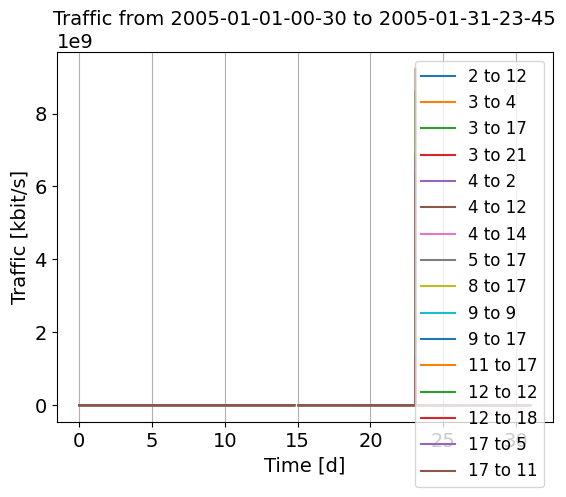

In [77]:
threshold = 10**9 # traffic above this threshold are considered "to be checked"
faulty_pairs = np.empty((0,2), int) # contains the pairs of nodes that contains abnormal values

for i in range(1, 23+1): # find the tuple that contains value above threshold
  for j in range(1, 23+1):

    time_series = data_kbit[id2index(i), id2index(j),:]

    if not np.isnan(time_series).all():
      faulty_max = np.nanmax(time_series)
      idx = np.nanargmax(time_series)
    else:
      continue

    if faulty_max > threshold:

        print(f'Unrealistically high value {round(faulty_max, 2)} found: Source {i}, Destination {j}, Timestamp {idx}')
        faulty_pairs = np.append(faulty_pairs, [[i,j]], 0)

plot_trace(data_kbit, faulty_pairs, False) # plot the graph to see that they ALL overlap

Looking at graphs we can see this traffic spike overlaps the normal traffic by a significant amount. It's also visible that the spike is always in the same position (time stamp number 2219) for different source-destination pairs, so probably there is one file containing corrupted data.

We will now substitute this values on a temporary data matrix and check the format of the data.

Unrealistically high value 2591421304.52 substituted with NA: Source 2, Destination 12, Timestamp 2219
Unrealistically high value 2406204172.77 substituted with NA: Source 3, Destination 4, Timestamp 2219
Unrealistically high value 6335205746.49 substituted with NA: Source 3, Destination 17, Timestamp 2219
Unrealistically high value 1053754746.78 substituted with NA: Source 3, Destination 21, Timestamp 2219
Unrealistically high value 6317731968.74 substituted with NA: Source 4, Destination 2, Timestamp 2219
Unrealistically high value 4971086895.76 substituted with NA: Source 4, Destination 12, Timestamp 2219
Unrealistically high value 1145681100.48 substituted with NA: Source 4, Destination 14, Timestamp 2219
Unrealistically high value 6889276910.27 substituted with NA: Source 5, Destination 17, Timestamp 2219
Unrealistically high value 2270742444.97 substituted with NA: Source 8, Destination 17, Timestamp 2219
Unrealistically high value 3067685847.41 substituted with NA: Source 9, Des

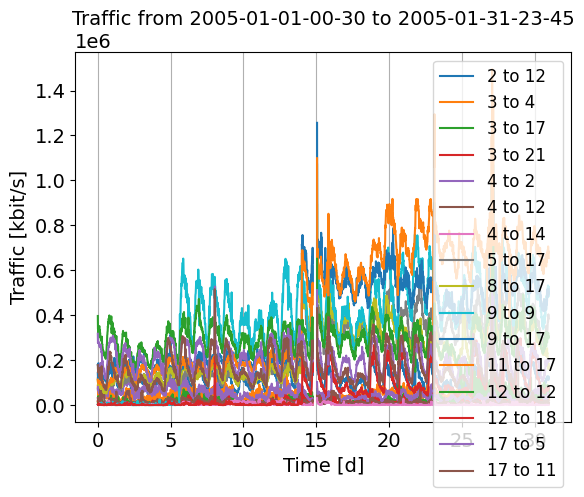

In [78]:
data_kbit_tmp = np.array(data_kbit)

for i in range(1, 23+1): # find the tuple that contains value above threshold
  for j in range(1, 23+1):

    time_series = data_kbit_tmp[id2index(i), id2index(j), :]

    if not np.isnan(time_series).all():
      faulty_max = np.nanmax(time_series)
      idx = np.nanargmax(time_series)
    else:
      continue

    if faulty_max > threshold:

        print(f'Unrealistically high value {round(faulty_max, 2)} substituted with NA: Source {i}, Destination {j}, Timestamp {idx}')
        data_kbit_tmp[id2index(i), id2index(j), idx] = np.nan

plot_trace(data_kbit_tmp, faulty_pairs, False) # plot the graph to see that they ALL overlap

The traffic traces, that previously were flat compared to the spike, now have a good looking shape. This supports the hypothesis that the file in question (number 2219) may be corrupted or contains some wrong data.

For this reason, we decided to discard the whole data of this time stamp, since the realiability of that data point can not be assured.

In [79]:
broken_id = 2219
data_kbit[:, :, broken_id] = np.nan
print(f"The broken ID is {broken_id}, which corresponds to the file {files[broken_id]}.\nAll data points from this file has been replaced with nan.")

The broken ID is 2219, which corresponds to the file IntraTM-2005-01-24-02-45.xml.
All data points from this file has been replaced with nan.


## Checking for NaNs

First we check which time series consist mostly of NaNs. These will be disregarded immediately, since they do not contain useful data.

The following table shows the number of not available values for each source-destination-pair. We subtract `missing_count` because that is the number of time frames where the file was missing and 1 because it was fauly, therefore there is no data available for any pair.

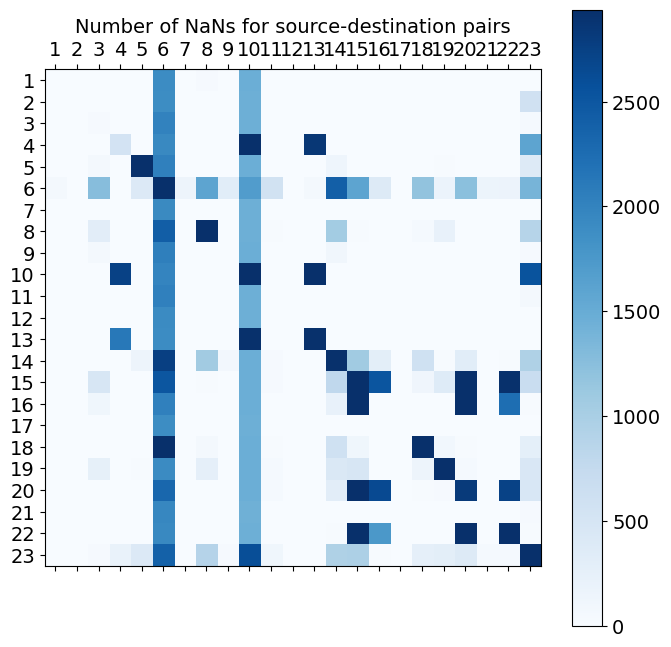

In [80]:
data_nan_number = np.sum(np.isnan(data_kbit).astype(int), axis=2)-(missing_count+1)

plot_matrix_NAs(data_nan_number)

Here we immediately see that there are a few sources and destinations which are mostly consisting of NaNs.

We decided that we will not consider any source-destination-pair with more than 100 missing values.

In [81]:
candidate_pairs = []

for i in range(1, 23+1):
  for j in range(1, 23+1):
    if data_nan_number[id2index(i), id2index(j)] <= 100:
      candidate_pairs.append((i,j))

print(f"{len(candidate_pairs)} of {23*23} pairs are still considered.")

398 of 529 pairs are still considered.


## Checking for almost constant values

First, we do a graphical check of the time series. This is useful to get an idea of the data and their structure, however, the scope of the data is too big to decide only on graphical evidence.

You can *scroll* through the data by just increasing `c` one by one to get an idea of it. The graph shows the data in kbit/s.

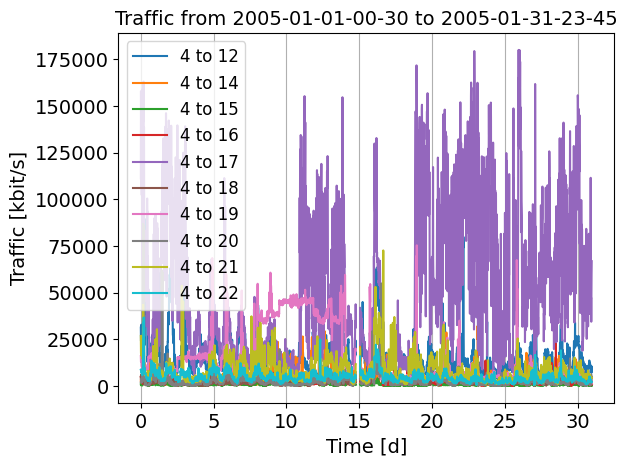

In [82]:
c=7
plot_trace(data_kbit, candidate_pairs[(c*10):(c*10)+10], channels=False)

Same as above, but the graph is now showing number of channels instead of kbit/s.

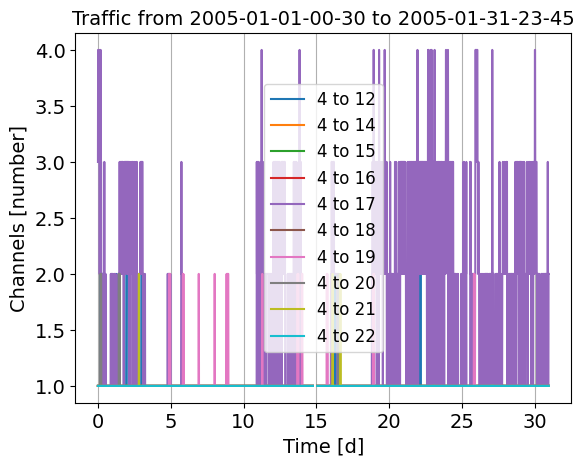

In [83]:
c=7
plot_trace(kbit2channels(data_kbit), candidate_pairs[(c*10):(c*10)+10], channels=True)

Therefore, we checked the variance of the time series in the second half, not considering the missing values. Unfortunately, more than half of the time series returned a variance of 0, which means they are constant the whole time.

We manually took a look at different time series considering their variance, and decided on the following rule if a source-destination-pair should be considered:


If the variance, ignoring missing values, of the channels time series is below $0.1$, it is discarded.

In [84]:
data_len = data_kbit.shape[2]
to_be_discarded = []

for p in candidate_pairs:
  half_var = np.nanvar(kbit2channels(data_kbit)[id2index(p[0]), id2index(p[1]), int(data_len/2):])

  if half_var <= 0.1:
    to_be_discarded.append(p)

In [85]:
candidate_pairs = [p for p in candidate_pairs if p not in to_be_discarded]

print(f"{len(candidate_pairs)} of {23*23} pairs are still considered.")

52 of 529 pairs are still considered.


So we see after applying the *filters* described above, we are now considering 52 pairs for our project. In detail, it's the following source-destination pairs:

In [86]:
print(candidate_pairs)

[(1, 1), (1, 2), (1, 7), (1, 17), (2, 4), (2, 12), (2, 13), (2, 18), (3, 2), (3, 4), (3, 17), (4, 1), (4, 2), (4, 3), (4, 7), (4, 17), (5, 9), (5, 17), (7, 4), (8, 9), (8, 12), (8, 17), (9, 8), (9, 9), (9, 12), (9, 17), (10, 5), (10, 7), (10, 8), (10, 9), (10, 11), (10, 12), (10, 14), (10, 17), (11, 2), (11, 12), (11, 17), (12, 2), (12, 4), (12, 12), (12, 13), (12, 17), (12, 18), (13, 2), (13, 12), (13, 17), (17, 4), (17, 5), (17, 11), (17, 12), (18, 2), (18, 12)]


## Interpolating data

As described above, we decided to interpolate the missing data points. While this can theoretically change the behaviour of the data, we are only considering time series which have less than 100 missing values, while we have more than 2900 time stamps, this is a neglegible danger.

In [87]:
data_kbit_filled = interpolate_data(data_kbit, matrix = True)

The function `interpolate_data` interpolates the whole 3D data matrix, so also the pairs we are not considering, because it was easier to handle it this way. Therefore, the warnings above can be ignored, since it only affects pairs we can not consider anyway.

## Converting kbit to channels

In order to avoing converting from kbit/s to channels all the time, we create one 3D data matrix containing channels instead of kbit/s.

In [88]:
data_channels_filled = kbit2channels(data_kbit_filled)

## Visualizing data

First we again look at the normal traffic traces from speficic pairs. For example, the traffic from node 11 to node 17 visible below shows interesting behaviour, for the first 14 days the traffic is quite low, but with visible differences between day and night, then the traffic increases by a lot, with a very big change around day 27.

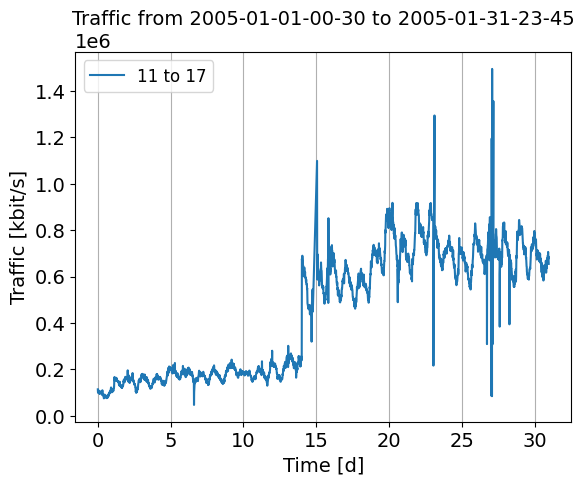

In [89]:
plot_trace(data_kbit_filled, [(11,17),])

The following plot shows the variance of the different pairs. The darker each point, the higher the variance of the traffic of this pair. We see that the pair `(17,11)`, which we also considered above, has by far the highest variance of all pairs. There are a few others with high values, but the average is quite low.

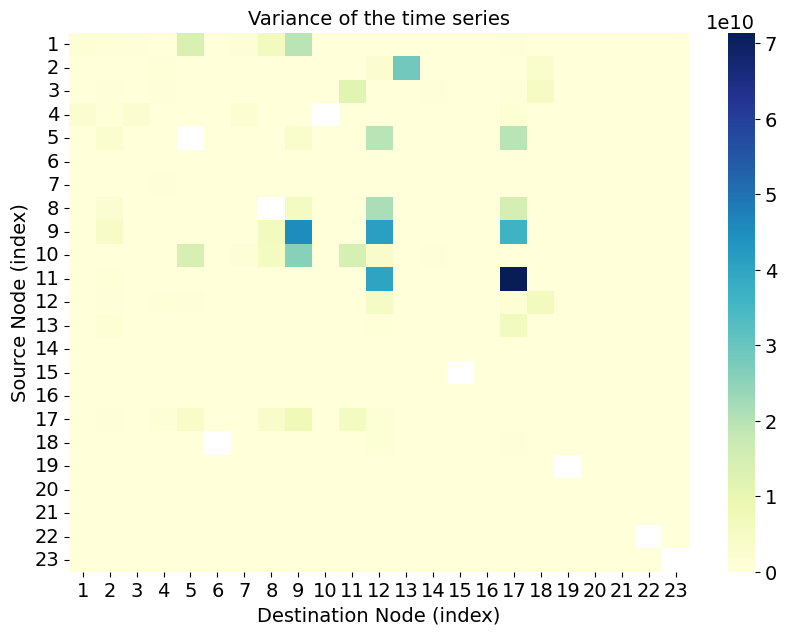

In [90]:
plot_matrix_traffic(data_kbit_filled)

The following two plots show the difference in variance between a node with high variance (again `(11,17)`) and one with low variance. It is also interesting to see the difference between the representation as kbit/s and as channels.

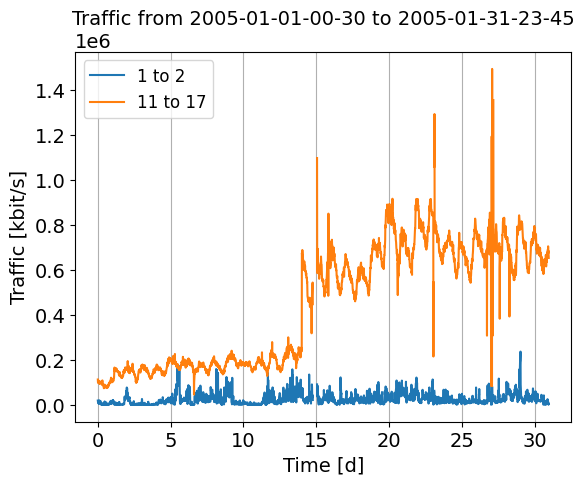

In [91]:
pairs = [(1,2), (11, 17)]
plot_trace(data_kbit, pairs)

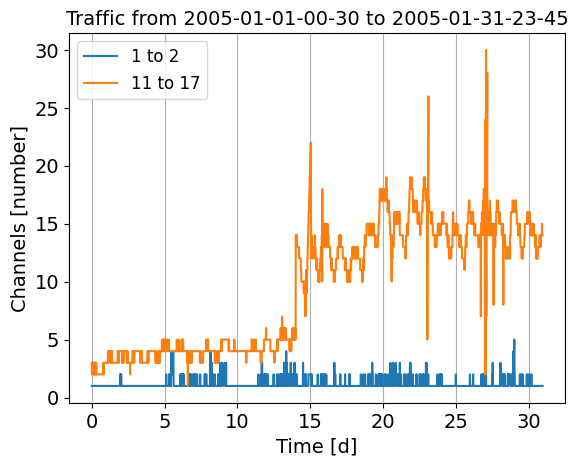

In [92]:
plot_trace(data_channels_filled, pairs, channels=True)

# Model Building

Now we actually start building models and trying to answer the research question of this assignment, namely comparing predicting the number of channels with predicting the traffic in kbit/s and converting that to channels.

We are considering an LSTM model, which directly predicts the traffic given some history, and will compare that with a feature-based approach. For that, we are considering a linear regression model as a baseline and an Artificial Neural Network (ANN).

## LSTM

An LSTM (Long Short-Term Memory) model is a type of recurrent neural network (RNN) architecture that is designed to capture long-term dependencies and handle sequential data (in our case the time series) effectively. It incorporates memory cells and gates to selectively retain and forget information over time, allowing it to process and predict sequences with improved accuracy.

### Helper Functions

The following function receives the whole data matrix, one source-destination-pair and the number of lookback hours as an input. It then extracts the corresponding time series from the data matrix and creates the data in the format needed for the LSTM model: The explaining variable `X` contains the past for a specific time (`lookback_hours`), so is a list of lists of length `lookback_hours`$*4$, while the explained variable contains the corresponding following observation.

In [ ]:
def generatedataset_LSTM(data, src, dst, lookback_hours = 24):

    timeseries = data[id2index(src), id2index(dst), :]

    timeseries_clean = timeseries.reshape(-1,1)

    X, y = [], []

    lookback_samples = int(lookback_hours * 4)

    for i in range(len(timeseries_clean)):
        last_sample = i + lookback_samples
        if last_sample > len(timeseries_clean) - 1:
            break
        X.append(timeseries_clean[i : last_sample])
        y.append(timeseries_clean[last_sample])

    X = np.array(X)
    y = np.array(y)

    return X, y

For LSTM, we can not simple take the data and split it into two parts, because we need to make sure that there is no overlap between training and test data. The following function can do that, but it must be kept in mind that the variable `gap_hours` must be bigger than the `lookback_hours` used to create the variables `X` and `y`.

In [ ]:
def train_test_split_LSTM(X, y, test_days, gap_hours):

    gap = gap_hours*4
    test_samples = test_days*24*4
    train_samples = int(X.shape[0] - test_samples - gap)

    test_samples_start = int(train_samples + gap)

    X_train = X[: train_samples]
    y_train = y[: train_samples]

    X_test = X[test_samples_start :]
    y_test = y[test_samples_start :]

    return X_train, X_test, y_train, y_test

In the following function most of the magic happens: It first creates the data in the required format, splits it into train and test set, and can then perform a grid search for different parameters and returns an detailled result data frame.

It receives the following input:
- `data`: 3D-Matrix containing all data, either traffic in kbit/s, or channels.
- `scale`: Boolean value describing if the data should be scaled before fitting the models.
- `model_params`: Dictionary telling which values should be considered for which parameters. The dictionary must contain the following parameters:
  - `thinkback`: How far should the model look into the future
  - `gap`: How big should the gap between train and test data be
  - `n_layers`:  How many layers should the LSTM have
  - `n_neurons`: How many neurons should each layer have
  - `n_epochs`: How many epochs should be fitted
  - `opti`: Which optimizer should be used
  
  Generally, a grid search is performed, meaning each parameter value is combined with each value. However, there are a few exceptions, reducing the total number of combinations:
  - We are only considering cases in which `thinkback=gap`. This was mainly done becase of the long fitting times and can easily be undone.
  - `n_layers=len(n_neurons)` must hold. Otherwise we would not know how many neurons each layer has.
- `pairs`: List of tuples or lists with length 2 indicating which source-destination pairs should be considered to fit the LSTM model.
- `test_days`: How many of the 31 available days should be in the test set. In our case, we are always considering a test set of 7 days.
- `quiet`: Should the progress of fitting models be printed. Contains useful information, but is quickly getting messy.
- `show_plot`: After each fitted model, should a plot comparing the true and fitted data be printed.
- `return_only_results`: Boolean value describing what the return value of the function should be:
  - `True`: Function returns a dictionary containing one key-value pair. The value is a pandas data frame showing the MSE, MAE and $R^2$ value for all considered parameter combinations.
  - `False`: In addition to the results data frame described above, the dictionary also contains the following keys:
    - `last_model`: Tensorflow model which was last fitted. While this seems oddly specific, it is used when only one parameter combination was considered and the model should be accessed.
    - `scaler`: scikit-learn scaler used to scale the data. This is necessary if further predictions will be made.
    - `data`: The considered data for fitting the models. If `scale=True` it contains both the scaled and unscaled data.



In [ ]:
def fit_LSTM(data, scale, pairs, model_params, test_days=7, quiet=True, show_plot=False, return_only_results=True):

  results = []

  scaler = MinMaxScaler()

  print(f"optimizer\tthinkback\tgap\t\tepoch\t\tlayers\t\tneurons")
  for thinkback in model_params["thinkback"]:
    for gap in model_params["gap"]:

      # Skipping parameter combination if gap is not equal to thinkback
      if gap != thinkback:
          continue

      first = True

      for s, d in pairs:
        X, y = generatedataset_LSTM(data, s, d, thinkback)
        X_train, X_test, y_train, y_test = train_test_split_LSTM(X, y, test_days, gap)

        if first:
          X_train_all, X_test_all, y_train_all, y_test_all = X_train, X_test, y_train, y_test
          first = False
          continue

        X_train_all = np.concatenate([X_train_all, X_train])
        X_test_all = np.concatenate([X_test_all, X_test])
        y_train_all = np.concatenate([y_train_all, y_train])
        y_test_all = np.concatenate([y_test_all, y_test])

      if scale:
        X_train_shape = X_train_all.shape
        X_test_shape = X_test_all.shape

        X_train_scaled = (scaler.fit_transform(X_train_all.reshape((np.prod(X_train_shape), 1)))).reshape(X_train_shape)
        X_test_scaled = (scaler.transform(X_test_all.reshape((np.prod(X_test_shape), 1)))).reshape(X_test_shape)
        y_train_scaled = scaler.transform(y_train_all)
        y_test_scaled = scaler.transform(y_test_all)

      for n_layers in model_params["n_layers"]:
        for n_neurons in model_params["n_neurons"]:

          # Skipping parameter combination if length of vector describing number
          # of neurons is not equal to the number of layers
          if len(n_neurons) != n_layers:
            continue

          for opti in model_params["opti"]:
            for n_epochs in model_params["n_epochs"]:

              model = Sequential()
              for i in range(n_layers):
                model.add(LSTM(n_neurons[i],
                              return_sequences = False if i == (n_layers-1) else True))
              model.add(Dense(1))

              model.compile(optimizer=opti, loss="mean_squared_error")
              print(f"{opti}\t\t{thinkback}h\t\t{gap}h\t\t{n_epochs}\t\t{n_layers}\t\t{n_neurons}")

              if scale:
                model.fit(X_train_scaled, y_train_scaled, epochs=n_epochs, verbose=not quiet)
                y_pred = model.predict(X_test_scaled, verbose=not quiet)
                mse, mae, r2 = performance_eval(y_test_scaled, y_pred, print_results=not quiet, show_graph=show_plot)
              else:
                model.fit(X_train_all, y_train_all, epochs=n_epochs, verbose=not quiet)
                y_pred = model.predict(X_test_all, verbose=not quiet)
                mse, mae, r2 = performance_eval(y_test_all, y_pred, print_results=not quiet, show_graph=show_plot)

              results.append({"thinkback": thinkback,
                              "gap": gap,
                              "n_layers": n_layers,
                              "n_neurons": n_neurons,
                              "n_epochs": n_epochs,
                              "opti": opti,
                              "mse": mse,
                              "mae": mae,
                              "r2": r2})
  if return_only_results:
    return {"results": results}
  else:
    return {"results": results,
            "last_model": model,
            "scaler": scaler,
            "data": {"X_train": X_train_all,
                     "X_test": X_test_all,
                     "y_train": y_train_all,
                     "y_test": y_test_all,
                     "X_train_scaled": X_train_scaled if scale else None,
                     "X_test_scaled": X_test_scaled if scale else None,
                     "y_train_scaled": y_train_scaled if scale else None,
                     "y_test_scaled": y_test_scaled if scale else None}}

### Model Fitting

The functions defined above, both in the general and the LSTM part, will help a lot to keep the interesting part of this project as clean as possible. In the following section, different LSTM models will be fitted (different parameters, different data, ...) and compared.

#### Predicting traffic

We want to find the parameter combination which yields the best possible model. To achieve this, we create a parameter grid and fit and evaluate the corresponding model for each combination.

Here, and also in a few following chunks, it is first checked whether a file containing the result of the action to be performed exists. This is done because it takes multiple hours to perform the calculations (the grid search in this case), while the upload of the results only takes a few seconds to minutes. It therefore also helps to make our resuls traceble and to some part reproducible.

In [ ]:
if os.path.isfile("results_df_LSTM_kbit.csv"):
  results_df_LSTM_kbit = pd.read_csv("results_df_LSTM_kbit.csv", index_col=0)
else:
  parameters_kbit = {"thinkback": [8, 16, 24, 32],
                     "gap": [8, 16, 24, 32],
                     "n_layers": [3, 5, 7],
                     "n_neurons": [[10,7,3], [15, 12, 9, 6, 3], [18, 15, 12, 12, 9, 6, 3]],
                     "n_epochs": [20],
                     "opti": ["adam"]}

  results_LSTM_kbit = fit_LSTM(data = data_kbit_filled,
                               scale = True,
                               pairs = candidate_pairs,
                               model_params = parameters_kbit,
                               test_days=7,
                               quiet = True,
                               show_plot = False,
                               return_only_results=True)

  results_df_LSTM_kbit = pd.DataFrame(results_LSTM_kbit["results"])
  results_df_LSTM_kbit.to_csv("results_df_LSTM_kbit.csv")

 The following table shows the result of the grid search. The first columns describe the considered parameters, while the last three parameters stand for the achieved MSE, MAE and $R^2$ scores.

In [ ]:
display(results_df_LSTM_kbit)

,thinkback,gap,n_layers,n_neurons,n_epochs,opti,mse,mae,r2
0,8,8,3,"[10, 7, 3]",20,adam,0.000545,0.008714,0.959872
1,8,8,5,"[15, 12, 9, 6, 3]",20,adam,0.000554,0.007934,0.959184
2,8,8,7,"[18, 15, 12, 12, 9, 6, 3]",20,adam,0.000584,0.007869,0.956979
3,16,16,3,"[10, 7, 3]",20,adam,0.000571,0.007928,0.957953
4,16,16,5,"[15, 12, 9, 6, 3]",20,adam,0.000590,0.007875,0.956552
5,16,16,7,"[18, 15, 12, 12, 9, 6, 3]",20,adam,0.000538,0.008491,0.960400
6,24,24,3,"[10, 7, 3]",20,adam,0.000609,0.008478,0.957774
7,24,24,5,"[15, 12, 9, 6, 3]",20,adam,0.000597,0.008184,0.958577
8,24,24,7,"[18, 15, 12, 12, 9, 6, 3]",20,adam,0.000643,0.008678,0.955434
9,32,32,3,"[10, 7, 3]",20,adam,0.000639,0.008296,0.955730


Now we fit the model which gave us the best parameters to perform the prediction on the test set. The best parameters are automatically extracted from the data frame above, however we set the number of epochs to 50 to achieve an even better optimized model. This could not be done before since the run time would just have been too long.

In [ ]:
results_df_LSTM_kbit_best_row = results_df_LSTM_kbit.iloc[results_df_LSTM_kbit["mse"].idxmin(),:]

best_parameters_kbit = {"thinkback": [results_df_LSTM_kbit_best_row["thinkback"]],
                        "gap": [results_df_LSTM_kbit_best_row["gap"]],
                        "n_layers": [results_df_LSTM_kbit_best_row["n_layers"]],
                        "n_neurons": [ast.literal_eval(results_df_LSTM_kbit_best_row["n_neurons"])],
                        "n_epochs": [50],
                        "opti": [results_df_LSTM_kbit_best_row["opti"]]}

This are the parameters which will be used for the final model:

In [ ]:
pprint(best_parameters_kbit)

{'gap': [16],
 'n_epochs': [50],
 'n_layers': [7],
 'n_neurons': [[18, 15, 12, 12, 9, 6, 3]],
 'opti': ['adam'],
 'thinkback': [16]}


As above, the model is extracted from a file to speed things up, if the file is not available, the fitting process starts.

In [ ]:
if os.path.isfile("results_best_LSTM_kbit.pickle"):
  with open("results_best_LSTM_kbit.pickle", "rb") as f:
    results_best_LSTM_kbit = pickle.load(f)
    f.close()
else:
  results_best_LSTM_kbit = fit_LSTM(data = data_kbit_filled,
                                    scale = True,
                                    pairs = candidate_pairs,
                                    model_params = best_parameters_kbit,
                                    test_days=7,
                                    quiet = False,
                                    show_plot = True,
                                    return_only_results=False)

In the following chunk, we extract the scaler and the test data from the result object to perform the evaluation.

In [ ]:
scaler_LSTM = results_best_LSTM_kbit["scaler"]

X_true_kbit_scaled = results_best_LSTM_kbit["data"]["X_test_scaled"]
y_pred_kbit_scaled = results_best_LSTM_kbit["last_model"].predict(X_true_kbit_scaled)
y_pred_kbit = scaler_LSTM.inverse_transform(y_pred_kbit_scaled)
y_pred_kbit_channels = kbit2channels(y_pred_kbit)

y_true_kbit = results_best_LSTM_kbit["data"]["y_test"]
y_true_kbit_channels = kbit2channels(y_true_kbit)

 627/1092 [================>.............] - ETA: 19s

After fitting the models, we can now evaluate them:

In [ ]:
perf_LSTM_kbit = performance_eval(y_true_kbit, y_pred_kbit, ylabel="Scaled Traffic")

In [ ]:
eval_channels_LSTM_kbit = evaluate_channels(y_true_kbit_channels, y_pred_kbit_channels)
print(eval_channels_LSTM_kbit)

We see that the model performs quite well: The predicted traffic is really close to the true data. Also when considering the number of incorrectly predicted channels, 14.5% is a strong value.

#### Predicting channels

In the previous chapter, we predicted the traffic in kbit/s and converted that to channels. Now we follow a different approach, building a model which directly predicts the number of channels. However, the procedure will be mostly the same. As before, we first perform a grid search to find the best parameter combination.

In [ ]:
if os.path.isfile("results_df_LSTM_channels.csv"):
  results_df_LSTM_channels = pd.read_csv("results_df_LSTM_channels.csv", index_col=0)
else:
  parameters_channels = {"thinkback": [8, 16, 24, 32],
                         "gap": [8, 16, 24, 32],
                         "n_layers": [3, 5, 7],
                         "n_neurons": [[10,7,3], [15, 12, 9, 6, 3], [18, 15, 12, 12, 9, 6, 3]],
                         "n_epochs": [20],
                         "opti": ["adam"]}

  results_LSTM_channels = fit_LSTM(data = data_channels_filled,
                                   scale = False,
                                   pairs = candidate_pairs,
                                   model_params = parameters_channels,
                                   test_days=7,
                                   quiet = True,
                                   show_plot = False,
                                   return_only_results=True)

  results_df_LSTM_channels = pd.DataFrame(results_LSTM_channels["results"])
  results_df_LSTM_channels.to_csv("results_df_LSTM_channels.csv")

In [ ]:
display(results_df_LSTM_channels)

And again we extract the best parameter combination automatically, but set the number of epochs to 50, and then fit the model with the best parameters.

In [ ]:
results_df_LSTM_channels_best_row = results_df_LSTM_channels.iloc[results_df_LSTM_channels["mse"].idxmin(),:]

best_parameters_channels = {"thinkback": [results_df_LSTM_channels_best_row["thinkback"]],
                            "gap": [results_df_LSTM_channels_best_row["gap"]],
                            "n_layers": [results_df_LSTM_channels_best_row["n_layers"]],
                            "n_neurons": [ast.literal_eval(results_df_LSTM_channels_best_row["n_neurons"])],
                            "n_epochs": [50],
                            "opti": [results_df_LSTM_channels_best_row["opti"]]}

In [ ]:
pprint(best_parameters_channels)

In [ ]:
if os.path.isfile("results_best_LSTM_channels.pickle"):
  with open("results_best_LSTM_channels.pickle", "rb") as f:
    results_best_LSTM_channels = pickle.load(f)
    f.close()
else:
  results_best_LSTM_channels = fit_LSTM(data = data_channels_filled,
                                        scale = False,
                                        pairs = candidate_pairs,
                                        model_params = best_parameters_channels,
                                        test_days=7,
                                        quiet = False,
                                        show_plot = True,
                                        return_only_results=False)

Now we can evaluate the model again. First we take a look at the traffic trace comparing predicted and actual values:

In [ ]:
X_true_channels = results_best_LSTM_channels["data"]["X_test"]
y_true_channels = results_best_LSTM_channels["data"]["y_test"]

y_pred_channels = np.round(results_best_LSTM_channels["last_model"].predict(X_true_channels))

In [ ]:
_, _, _ = performance_eval(y_true_channels, y_pred_channels, normalized=False, ylabel="Channels")

Note that this plot and measures are not directly comparable to the evaluation before, since a different variable is predicted. For this reason, we mainly focus on the ratio of incorrectly classified time stamps.

In [ ]:
eval_channels_LSTM_channels = evaluate_channels(y_true_channels, y_pred_channels)
print(eval_channels_LSTM_channels)

We see that the ratio of incorrectly classified time stamps is still very low, but slightly higher than for the model predicting kbit/s. However, this is reasonable since the time series in kbit/s is just richer in information, giving the model more room to learn.

It's also ineresting to see that the first model (predicting kbit/s) tends to overprovision, while the second model (predicting channels) tends to give to provide too little channels.

## Linear Regression - ANN
In this section, we develop a different approach (feature-based) to finally make a comparison with the LSTM part.
We are going to extract features from the data and develop 2 models to predict traffic:

1.   **Linear regression**
2.   **Artificial Neural Network**




###Helper Functions



#### Scaling

This function is useful to scale both X and y simultaneously (with 2 different scaler objects). It gives back the scaled version of X and y and also the 2 scaler used, in order to unscale.

In [93]:
# function to scale and unscale the data for the following models
def scale_data(X_unscaled, y_unscaled):

  scaler_X = MinMaxScaler()
  scaler_y = MinMaxScaler()
  #The motivation to use this scaling include robustness to very small standard
  #deviations of features and preserving zero entries in sparse data

  X = scaler_X.fit_transform(X_unscaled)
  y = scaler_y.fit_transform(y_unscaled.reshape(-1, 1))

  return X, y, scaler_X, scaler_y

#### Features Extraction and splitting dataset

This function is used to split the data into train and test set using the predefined function *train_test_split*. We set the *shuffle* parameter to false so that we have the data in chronological order. The test size is exactly 7 days (the last 7 days of the month) while the training set contains all the first 24 days.

In [94]:
# we set 24 days over 31 as training set and the remaining 7 as testing set
def train_test_split_features(X, y, test_days = 7):
#Inputs:  - X: matrix of features (the numpy ndarray version) of a specific pair
#         - y: outputs vector (the numpy array) of a specific pair
#         - percentage_training: percentage of data of (X,y) to store in training set (X_train, y_train)
#Outputs: return X_train, X_test, y_train, y_test

  n_test = test_days*24*4

  X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = n_test)

  return X_train, X_test, y_train, y_test


The `all_features_extraction` is the core of the two following models since it's the function that extract the features and build the dataset from which the models will fit and predict the traffic.

`Input`:

*   `data_tot`: numpy array with all the traffic values for the entire month of January 2005
*   `pairs`: pair of nodes we are interested in to extract the features
*    `encode_id`: boolean to specify if OneHotEncoder has to be used or not


`Outputs`: return X_train, X_test, y_train, y_test  where

* `X` is the features matrix where each row is a given quarter of hour of a day, repeated for all the hours/days in the dataset, and has the following features:
        1. 'source' node
        2. 'destination' node
        3. 'day_of_week' : 0=monday, 1=tuesday, ... (knowing that January 1st 2005 was a Saturday-5, 2nd was a Sunday-6, and so on...)
        4. 'hour' : hour of the day
        5. 'working' : binary, =1 if working, =0 if holiday
        6. 'prev_hour' : traffic value of the last hour
        7. 'prev_12_hours': traffic value for the last 12 hours
        8. 'prev_day' : traffic value of last day (same time)
* `y` is the output vector, i.e., it has traffic values for the current day/hour (that we want to predict based on X)
* X and y are splitted by considering 24 days out of 31 as training set and the remaining 7 days as testing set
* X and y are  unscaled (i.e., with real features/output values)

In [95]:
# new feature extraction function to extract the dataset for all the candidate_pairs
def all_features_extraction(data_tot, pairs, encode_id=False):

  first = True

  # array to identify holidays indexes
  weekend_vect = np.array([1,2,6,8,9,15,16,22,23,29,30])
  # weekend_vect = np.array([0,1,5,7,8,14,15,21,22,28,29])

  total_src, total_dst, total_day, total_working, total_hour, total_prev_hour, total_prev_12hours, total_prev_day = np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
  y_unscaled = np.array([])

  ########## FEATURES EXTRACTION ################
  for src, dst in pairs:

    X_pair, y_pair = np.array([]), np.array([])

    data = data_tot[id2index(src), id2index(dst), :]  # time series of the pair (src, dst)

    #source and destination
    src_vect = np.full(len(data), src)   # vector of index of source node
    dst_vect = np.full(len(data), dst)   # vector of index of destination node

    day_of_the_week = [(int(f.split('-')[3])+4)%7 for f in files]   # +4 since january 1st is Saturday = day5

    hour_vect = [int(f.split('-')[4])%24 for f in files]

    working_vect = [0 if int(f.split('-')[3]) in weekend_vect else 1 for f in files]

    # first hour has only 4 values and the features is forced to be the traffic of the same hour
    prev_hour_vect = np.array([])
    for i in range(0,4):
      prev_hour_vect = np.append(prev_hour_vect, np.nan)

    # first 12 hours have 48 values and their features are forced to be the same traffic
    prev_12hours_vect = np.array([])
    for i in range(0,48):
      prev_12hours_vect = np.append(prev_12hours_vect, np.nan)

    # first day has 94 values and the features is forced to be the traffic of the same day
    prev_day_vect = np.array([])
    for i in range(0,96):
      prev_day_vect = np.append(prev_day_vect, np.nan)

    for i in range(len(data)):
      if i < 4:
        continue # skip the first hour, already inserted above
      elif i < 48:
        prev_hour_vect = np.append(prev_hour_vect, data[i-48])
        continue
      elif i < 96:      # skip the first day, already inserted above (we insert only  in prev_hour_vect)
        prev_hour_vect = np.append(prev_hour_vect, data[i-4])
        prev_12hours_vect = np.append(prev_12hours_vect, data[i-48])
        continue

      prev_hour_vect = np.append(prev_hour_vect, data[i-4])
      prev_12hours_vect = np.append(prev_12hours_vect, data[i-48])
      prev_day_vect = np.append(prev_day_vect, data[i-96])

    # print(len(src_vect), len(dst_vect), len(day_of_the_week), len(hour_vect), len(working_vect), len(prev_hour_vect), len(prev_12hours_vect), len(prev_day_vect))
    ####################################################

    categorical_vects = np.column_stack([src_vect, dst_vect, day_of_the_week, hour_vect, working_vect])

    if first and encode_id:
      encoder = OneHotEncoder(categories=[np.arange(0,23),
                                          np.arange(0,23),
                                          np.arange(0,7),
                                          np.arange(0,24),
                                          [0, 1]],
                              sparse_output=False)
      encoder.fit(categorical_vects)

    if encode_id:
      categorical_vects = encoder.transform(categorical_vects)

    X_pair = np.column_stack([categorical_vects, prev_hour_vect, prev_12hours_vect, prev_day_vect])
    y_pair = data

    X_train_pair, X_test_pair, y_train_pair, y_test_pair = train_test_split_features(X_pair, y_pair)

    if first:
      X_train, X_test, y_train, y_test = X_train_pair, X_test_pair, y_train_pair, y_test_pair
      first = False
      continue

    X_train = np.concatenate([X_train, X_train_pair])
    X_test = np.concatenate([X_test, X_test_pair])
    y_train = np.concatenate([y_train, y_train_pair])
    y_test = np.concatenate([y_test, y_test_pair])

  return X_train, X_test, y_train, y_test #X_unscaled, y_unscaled are numpy ndarrays

#### Print comparison among methods

In [96]:
# in this cell we compare the performance metrics for the 2 approaches
# 1) predict the kbit and then convert into channels (model works with the traffic in kbit)
# 2) directly predict the channels from the model (model works with the traffic in #channels required)

def compare_approaches(mse, mae, r2, conv_metrics):
  print("Performance metrics for kbit...")
  print("MSE: {}; MAE: {}; R2: {}".format(
      mse[0],
      mae[0],
      r2[0]))

  print("\n-----------------------------------\n")

  print("Performance metrics for channels converted from kbit...")
  print("MSE: {}; MAE: {}; R2: {}; incorrect_ratio: {}; under: {}; over: {} \n".format(
      mse[1],
      mae[1],
      r2[1],
      conv_metrics[0]['incorrect_ratio'],
      conv_metrics[0]['under'],
      conv_metrics[0]['over']))

  print("Performance metrics for channels predicted from the model...")
  print("MSE: {}; MAE: {}; R2: {}; incorrect_ratio: {}; under: {}; over: {}".format(
      mse[2],
      mae[2],
      r2[2],
      conv_metrics[1]['incorrect_ratio'],
      conv_metrics[1]['under'],
      conv_metrics[1]['over']))


### **Linear Regression**

Linear regression is a statistical modeling technique used to understand the relationship between a dependent variable and one or more independent variables (features) by fitting a linear equation to the observed data.
It aims to find the best-fitting line that minimizes the difference between the predicted and actual values of the dependent variable that in our case is the traffic flowing through the nodes of the network.

In [99]:
def pred_linreg(X_train, y_train):
  # step-1: create a cross-validation scheme
  folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

  # step-2: specify range of hyperparameters to tune
  hyper_params = [{'n_features_to_select': list(range(1, 14))}]


  # step-3: perform grid search
  # 3.1 specify model
  lm = LinearRegression()
  lm.fit(X_train, y_train)
  rfe = RFE(lm)

  # 3.2 call GridSearchCV()
  model_cv = GridSearchCV(estimator = rfe,
                          param_grid = hyper_params,
                          scoring= 'r2',
                          cv = folds,
                          verbose = 1,
                          return_train_score=True)

  # fit the model
  model_cv.fit(X_train, y_train)

  return model, 1

In [100]:
# def train_linreg(X, y):
#   # Input: training set X and y
#   # Output: 1) fitted model
#   #         2) training duration

#   print('Training a linear regression model...')

#   model = LinearRegression()
#   t0 = time.time()

#   model.fit(X, y)

#   t1 = time.time()
#   training_time = round(t1-t0, 3)

#   y_pred = model.predict(X)
#   # r2 = model.score(X, y)
#   # mse = mean_squared_error(y, y_pred)

#   print('Training time [s]: ' + str(training_time))
#   # print('Final training R2 score is: ' + str(round(r2,3)))
#   # print('Final training MSE is: ' + str(round(mse,3)))

#   return model, training_time


#### Predicting kbit


In [101]:
# pass the total matrix data to get the dataset with features
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = all_features_extraction(data_kbit_filled, candidate_pairs, True)

print(X_train_unscaled.shape)
print(y_train_unscaled.shape)
print(X_test_unscaled.shape)
print(y_test_unscaled.shape)

(119808, 82)
(119808,)
(34944, 82)
(34944,)


Scale the training set and obtain the scaled version of X_train and y_train and the scalers used.

Then, scale also the testing set.

In [102]:
X_train, y_train, X_scaler, y_scaler = scale_data(X_train_unscaled, y_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)

In this cell we need to discard the nan values corresponding to the first rows of the dataset that has no traffic in the hour, 12 hours or day before.

In [103]:
valid_timestamps = ~np.isnan(X_train).any(axis=1)
# discard the nan values in the dataset
X_train = X_train[valid_timestamps, :]
y_train = y_train[valid_timestamps]

We traing the linear regression model with the training set and then predict the values of y with X_test. We clip the values so that predicted traffic is not negative.

In [104]:
linreg, train_duration_linreg = train_linreg(X_train, y_train)
#first we predict from X_test (scaled), then we unscale and finally we clip the results so that predicted traffic is not negative (traffic can't be negative)
y_pred_linreg = np.clip(y_scaler.inverse_transform(linreg.predict(X_test)), 0, None)

Training time [s]: 4.905


Evaluating the performance of the linear regression with a plot of true and predicted curves and also obtaining some metrics ($R^2$, MSE, MAE).


MSE: 1434785050.9090648, MAE: 15553.548226960167, R2 score: 0.9369659043641996


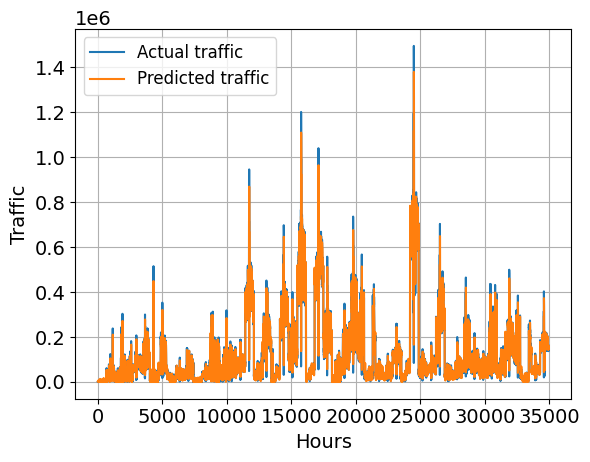

In [105]:
# 3 arrays to store the performance metrics for the 3 methods (kbit, converting channels from kbit, predict channels)
mse_linreg, mae_linreg, r2_linreg = [], [], []

# evaluate the performance of the true traffic in kbit and the predicted traffic in kbit
metrics_linreg_kbit = performance_eval(y_test_unscaled, y_pred_linreg, show_graph=True)
mse_linreg.append(metrics_linreg_kbit['MSE'])
mae_linreg.append(metrics_linreg_kbit['MAE'])
r2_linreg.append(metrics_linreg_kbit['R2'])

#### Performance in terms of channels

Converting predicted traffic from kbit to channels and evaluate the perfomance.
We can observe the difference in terms of r2 and MSE of:
*   performance of predicting the traffic in kbit
*   performance of predicted channels recovered from the conversion of traffic (predicted by the model) in kbit



MSE: 0.6996623168498168, MAE: 0.3113266941391941, R2 score: 0.9219871281402422


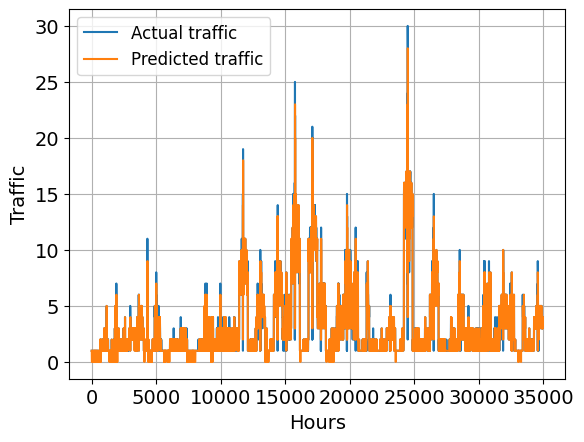

{'over': 5939, 'n_over': 4690, 'under': 4940, 'n_under': 3987, 'incorrect_ratio': 0.24831158424908426}


In [106]:
true_channels = kbit2channels(y_test_unscaled)
linreg_pred_channels = kbit2channels(y_pred_linreg)


metrics_linreg_conv_ch = performance_eval(true_channels, linreg_pred_channels, show_graph=True)  # evaluate the performance of the true #channels and the predicted #channels obtained by the conversion of kbit
mse_linreg.append(metrics_linreg_conv_ch['MSE'])
mae_linreg.append(metrics_linreg_conv_ch['MAE'])
r2_linreg.append(metrics_linreg_conv_ch['R2'])

conv_channels_metrics = new_evaluate_channels(true_channels.flatten(), linreg_pred_channels.flatten())  # give the incorrect number of channels predicted
ch_metrics_linreg = []
ch_metrics_linreg.append(conv_channels_metrics)
print(conv_channels_metrics)


#### Predicting channels directly in the model (without conversion from kbit)

In this section we basically repeat all the above steps but now we build and fit the LinReg model with data corresponding to the channel needed to accomodate the traffic.

In [107]:
# get the dataset passing as data the time series in terms of channels
X_train, X_test, y_train, y_test = all_features_extraction(data_channels_filled, candidate_pairs, True)

In [108]:
valid_timestamps = ~np.isnan(X_train).any(axis=1)
# get rid of nan values in the dataset
X_train = X_train[valid_timestamps, :]
y_train = y_train[valid_timestamps]

Training time [s]: 5.887

MSE: 0.6958276098901099, MAE: 0.3041151556776557, R2 score: 0.9224147008356165


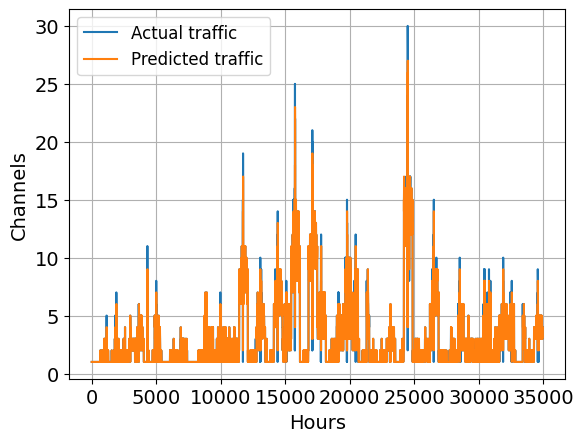

{'over': 5460,
 'n_over': 4129,
 'under': 5167,
 'n_under': 4161,
 'incorrect_ratio': 0.2372367216117216}

In [109]:
# we build the model with the unscaled training dataset
linreg, train_duration_linreg = train_linreg(X_train, y_train)

# as above, we predict from test dataset (unscaled) then we clip the results and finally we round the values to get integers (number of channels predicted)
y_pred_linreg_channels = np.round(np.clip(linreg.predict(X_test),0,None))

metrics_linreg_ch = performance_eval(y_test, y_pred_linreg_channels, show_graph=True, ylabel="Channels")
mse_linreg.append(metrics_linreg_ch['MSE'])
mae_linreg.append(metrics_linreg_ch['MAE'])
r2_linreg.append(metrics_linreg_ch['R2'])

dir_channels_metrics = new_evaluate_channels(y_test, y_pred_linreg_channels)
ch_metrics_linreg.append(dir_channels_metrics)
dir_channels_metrics

#### Compare the 2 approaches with linear regression

In [110]:
compare_approaches(mse_linreg, mae_linreg, r2_linreg, ch_metrics_linreg)

Performance metrics for kbit...
MSE: 1434785050.9090648; MAE: 15553.548226960167; R2: 0.9369659043641996

-----------------------------------

Performance metrics for channels converted from kbit...
MSE: 0.6996623168498168; MAE: 0.3113266941391941; R2: 0.9219871281402422; incorrect_ratio: 0.24831158424908426; under: 4940; over: 5939 

Performance metrics for channels predicted from the model...
MSE: 0.6958276098901099; MAE: 0.3041151556776557; R2: 0.9224147008356165; incorrect_ratio: 0.2372367216117216; under: 5167; over: 5460


### **Artificial Neural Network (ANN)**

Artificial Neural Network (ANN) is a computational model inspired by the structure and function of the human brain, consisting of interconnected nodes, also called "neurons", organized in layers.

It is used for various tasks but in our case we implemented it for regression, in particular to forecast traffic by learning from training data.

#### Helper Functions


**Create the ANN model**

 This function creates an Artificial Neural Network (ANN) model with customizable number of hidden layers, number of neurons in each layer, and activation function. The model is compiled with an optimizer and loss function, ready to be trained on data.




In [ ]:
def create_ANN_model(layers, neurons, activation):
  model = Sequential()

  model.add(Dense(neurons[0], activation=activation, input_dim=X_train.shape[1]))

  for i, layer in enumerate(range(2, layers+1)):
      model.add(Dense(neurons[i+1], activation=activation))

  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')

  return model

**Hyperparameters optimization** with grid search or random search

The `ANN_optimization` function performs hyperparameter optimization for the ANN model using the *param_grid* dictionary.

1. It initializes the best_params and best_score dictionaries to keep track of the best hyperparameters and corresponding scores.

2. It iterates over the specified values of layers, neurons, and activation from the param_grid.

3. For each combination of hyperparameters, it creates an ANN model using the create_ANN_model function.

4. The model is trained on the provided X_train and y_train data for a fixed number of epochs (in this case, 20).

5. After training, the model is used to make predictions on the training data, and the R2 score and mean squared error (MSE) are calculated.

6. The function updates the best_params and best_score if the current model achieves a lower MSE and a higher R2 score.

7. Once all combinations of hyperparameters have been tested, the function prints the best hyperparameters and their corresponding scores.

8. Finally, the function returns the best hyperparameters and their scores.

This function allows us to search for the best combination of hyperparameters for our ANN model using the specified parameter grid.

In [ ]:
param_grid = {"layers": [3, 5, 7],
              "neurons": [[15,10,5], [21,18,15,12,9], [24,21,18,15,12,9,6]],
              'activation': ['sigmoid', 'relu']}

def ANN_optimization(X_train, y_train, grid = param_grid):
  best_params = {"layers": [],
                 "neurons": [],
                 "activation": ""}

  best_score = {"mse": 1, "r2": 0}
  max_r2 = 0
  min_mse = 1

  for layers in param_grid["layers"]:
    for neurons in param_grid["neurons"]:
      if len(neurons) != layers:
        continue
      for activ in param_grid["activation"]:
        model = create_ANN_model(layers, neurons, activ)

        model.fit(X_train, y_train, epochs=20)

        y_pred = model.predict(X_train)
        r2 = r2_score(y_train, y_pred)
        mse = mean_squared_error(y_train, y_pred)

        # we select the best models in terms of min mse AND max r2
        if mse < min_mse and r2 > max_r2:
          best_params["layers"] = layers
          best_params["neurons"] = neurons
          best_params["activation"] = activ
          best_score["mse"] = mse
          best_score["r2"] = r2

  print("The best hyper parameters for ANN are {} with a score={}".format(best_params, best_score))
  return best_params, best_score


#### Predicting kbit

Obtain the dataset (train and test) and obtain the scaled version of X_train, y_train and X_test.

In [ ]:
# reobtain the dataset for ANN
# get the data (train and test set) in the unscaled version
X_train_unscaled, X_test_unscaled, y_train_unscaled, y_test_unscaled = all_features_extraction(data_kbit_filled, candidate_pairs, encode_id=False)

# second scale the data so that we scale train and test data separately as we did in LSTM
X_train, y_train, X_scaler, y_scaler = scale_data(X_train_unscaled, y_train_unscaled)
X_test = X_scaler.transform(X_test_unscaled)


Discard nan values from the datasets.

In [ ]:
valid_timestamps = ~np.isnan(X_train).any(axis=1)
# discard nan values
X_train = X_train[valid_timestamps, :]
y_train = y_train[valid_timestamps]

Here, and also in a few following chunks, it is first checked whether a file containing the result of the action to be performed exists. This is done because it takes a long time to perform the calculations (the grid search in this case), while the upload of the results only takes a few seconds.

In [ ]:
if os.path.isfile(data_folder+"Models/ANN_model_kbit.h5"):
  best_ANN_model = load_model(data_folder+"Models/ANN_model_kbit.h5")

else:
  # get the best parameters
  best_params, best_scores = ANN_optimization(X_train, y_train)

  best_ANN_model = create_ANN_model(best_params['layers'], best_params['neurons'], best_params['activation'])

  best_ANN_model.save(data_folder+"Models/ANN_model_kbit.h5")


1. The best_ANN_model is trained on the provided X_train and y_train data for a specified number of epochs (50 in this case) using the fit() method. The batch_size is set to 32.

2. After the model training is completed, the total training time for the ANN model is calculated.

3. The training set predictions (y_pred_ANN_train) are obtained using the trained best_ANN_model.

4. The performance of the ANN model on the training set is evaluated using the performance_eval() function.


Model training duration [s]: 982.84
3588/3588 [==============================] - 6s 2ms/step

MSE: 0.00030147975205096, MAE: 0.008880757206970747, R2 score: 0.9713719687207769


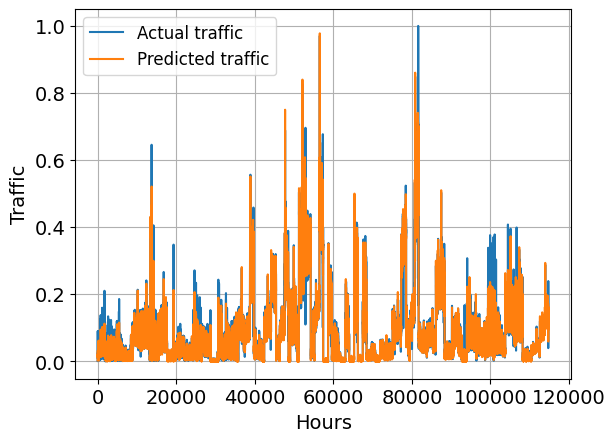

{'MSE': 0.00030147975205096,
 'MAE': 0.008880757206970747,
 'R2': 0.9713719687207769}

In [ ]:

t0 = time.time()
t0string = time.ctime(t0)

best_ANN_model.fit(X_train, y_train, epochs=100, batch_size = 32, verbose=False)

t1 = time.time()
t1string=time.ctime(t1)

training_time_NN = round(t1 - t0,2)
print('Model training duration [s]: {}'.format(training_time_NN))

y_pred_ANN_train = best_ANN_model.predict(X_train)
#show the performance of ANN for the training set
performance_eval(y_train, y_pred_ANN_train, show_graph=True)


Now, we predict the test set obtaining *y_pred_ANN* that is the clip, unscaled version of the predicted test set.

Then we evaluate the performance, showing the graph in kbit, between the true test set and the predicted one.

1092/1092 [==============================] - 2s 2ms/step

MSE: 1369705538.7311146, MAE: 15118.200614223935, R2 score: 0.9398250282392058


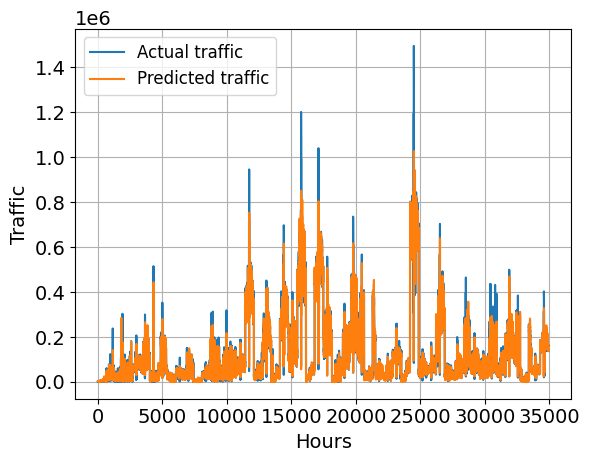

In [ ]:
# perform prediction using ANN model obtained in the previous cell

# first predict the test set (scaled), unscale and finally clip
y_pred_ANN = np.clip(y_scaler.inverse_transform(best_ANN_model.predict(X_test)), 0, None)
# show the result in terms of test set
metrics_ann_kbit = performance_eval(y_test_unscaled, y_pred_ANN, show_graph=True)

# save the result of predicting kbit
mse_ANN, mae_ANN, r2_ANN = [], [], []
mse_ANN.append(metrics_ann_kbit['MSE'])
mae_ANN.append(metrics_ann_kbit['MAE'])
r2_ANN.append(metrics_ann_kbit['R2'])


#### Performance in terms of channels for ANN

Obtain the performance in terms of channels from the conversion of kbit predicted above.


MSE: 0.6571371336996337, MAE: 0.28631524725274726, R2 score: 0.9267287178814831


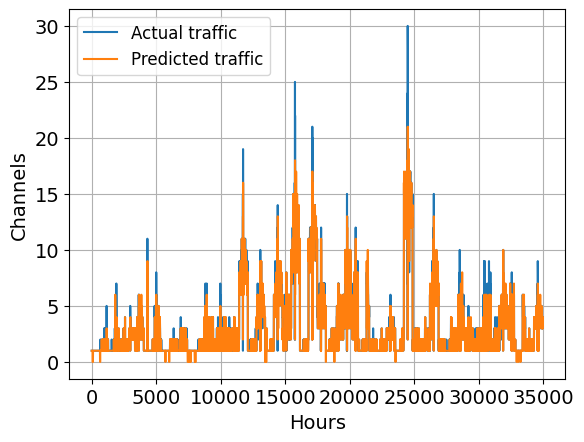

In [ ]:

#convert into channels
ANN_true_conv_ch = kbit2channels(y_test_unscaled)
ANN_pred_conv_ch = kbit2channels(y_pred_ANN)

# evaluate the performance of the conversion from kbit to channels
metrics_ann_conv_ch = performance_eval(ANN_true_conv_ch, ANN_pred_conv_ch, show_graph=True, ylabel="Channels")
mse_ANN.append(metrics_ann_conv_ch['MSE'])
mae_ANN.append(metrics_ann_conv_ch['MAE'])
r2_ANN.append(metrics_ann_conv_ch['R2'])


Evaluate the number of correct predicted channels.

In [ ]:
# evaluate the number of correct predicted channels from the conversion from kbit
ANN_conv_channels_metrics = new_evaluate_channels(ANN_true_conv_ch, ANN_pred_conv_ch)
ch_metrics_ANN = []
ch_metrics_ANN.append(ANN_conv_channels_metrics)
ANN_conv_channels_metrics

{'over': 5452,
 'n_over': 4196,
 'under': 4553,
 'n_under': 3700,
 'incorrect_ratio': 0.22596153846153846}

#### Predict directly channels with ANN

In this section we basically repeat all the above steps but now we build and fit the LinReg model with data corresponding to the channel needed to accomodate the traffic.

In [ ]:
# first: reobtain the dataset and work with unscaled version as we did with linreg
X_train, X_test, y_train, y_test = all_features_extraction(data_channels_filled, candidate_pairs, False)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(119808, 8)
(119808,)
(34944, 8)
(34944,)


In [ ]:
valid_timestamps = ~np.isnan(X_train).any(axis=1)
# discard nan values
X_train = X_train[valid_timestamps, :]
y_train = y_train[valid_timestamps]

Export and import the model already fitted if it has already done

In [ ]:
if os.path.isfile(data_folder+"Models/ANN_model_ch.h5"):
  best_ANN_model = load_model(data_folder+"Models/ANN_model_ch.h5")

else:
  # get the best parameters
  best_params, best_scores = ANN_optimization(X_train, y_train)

  best_ANN_model = create_ANN_model(best_params['layers'], best_params['neurons'], best_params['activation'])

  best_ANN_model.save(data_folder+"Models/ANN_model_ch.h5")

Model training duration [s]: 818.88
3588/3588 [==============================] - 7s 2ms/step

MSE: 0.2650851792559853, MAE: 0.27607792844308526, R2 score: 0.9611188579829693


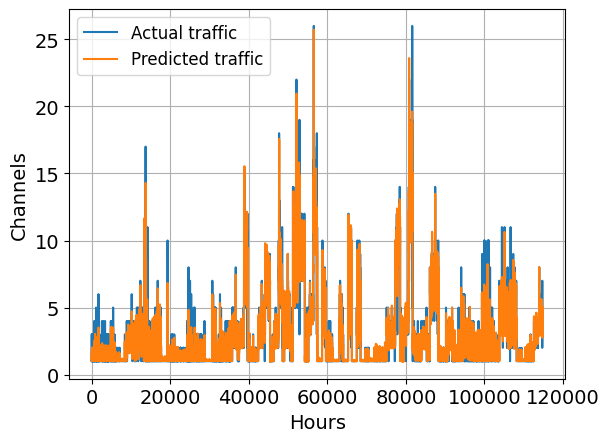

{'MSE': 0.2650851792559853,
 'MAE': 0.27607792844308526,
 'R2': 0.9611188579829693}

In [ ]:
t0 = time.time()
t0string = time.ctime(t0)

best_ANN_model.fit(X_train, y_train, epochs=100, batch_size = 32, verbose=False)

t1 = time.time()
t1string=time.ctime(t1)
training_time_NN = round(t1 - t0,2)
print('Model training duration [s]: {}'.format(training_time_NN))

# predict the train set
y_pred_ANN_train = np.clip(best_ANN_model.predict(X_train), 0, None)
# evaluate the performance for the training set
performance_eval(y_train, y_pred_ANN_train, show_graph=True, ylabel="Channels")


1092/1092 [==============================] - 2s 2ms/step

MSE: 0.6711309523809523, MAE: 0.29842032967032966, R2 score: 0.9251683966274677


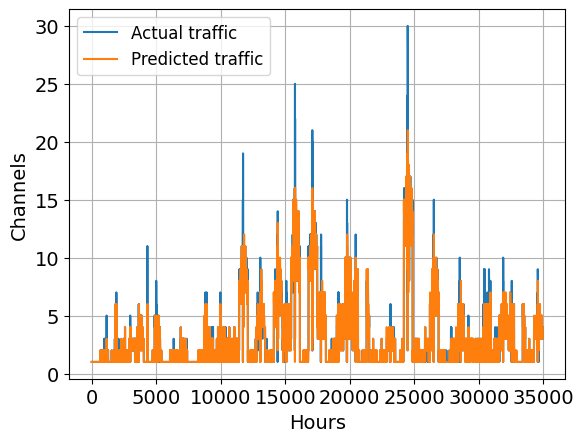

In [ ]:
# perform prediction using ANN model obtained in the previous cell

# predict the test set and clip it to obtain only positive values
y_pred_ANN = np.round(np.clip(best_ANN_model.predict(X_test), 0, None))
# evaluate the performance for the testing set
metrics_ann_ch = performance_eval(y_test, y_pred_ANN, show_graph=True, ylabel="Channels")

mse_ANN.append(metrics_ann_ch['MSE'])
mae_ANN.append(metrics_ann_ch['MAE'])
r2_ANN.append(metrics_ann_ch['R2'])

In [ ]:
# evaluate the correct predicted number of channels
ANN_dir_channels_metrics = new_evaluate_channels(y_test, y_pred_ANN)
ch_metrics_ANN.append(ANN_dir_channels_metrics)
ANN_dir_channels_metrics

{'over': 5366,
 'n_over': 4051,
 'under': 5062,
 'n_under': 4227,
 'incorrect_ratio': 0.236893315018315}

#### Compare the 2 approaches with ANN

In [ ]:
compare_approaches(mse_ANN, mae_ANN, r2_ANN, ch_metrics_ANN)

Performance metrics for kbit...
MSE: 1369705538.7311146; MAE: 15118.200614223935; R2: 0.9398250282392058

-----------------------------------

Performance metrics for channels converted from kbit...
MSE: 0.6571371336996337; MAE: 0.28631524725274726; R2: 0.9267287178814831; incorrect_ratio: 0.22596153846153846; under: 4553; over: 5452 

Performance metrics for channels predicted from the model...
MSE: 0.6711309523809523; MAE: 0.29842032967032966; R2: 0.9251683966274677; incorrect_ratio: 0.236893315018315; under: 5062; over: 5366


Extract the features for the entire dataset















































### ANN vs Linear Regression


In [ ]:
# comparison of the metrics between ANN and Linear Regression
# 1° value is about the prediction in kbit
# 2° value is about the prediction of channels converted from the predicted kbit
# 3° value is about the prediction of channels directly from the model (meaning that model works with the data referring to channels)
print('Metrics of Linear Regression...')
print(' r2:', r2_linreg, '\n mse:', mse_linreg, '\n training time:', train_duration_linreg, '[s]')

print('\nMetrics of ANN...')
print(' r2:', r2_ANN, '\n mse:', mse_ANN, '\n training time:', training_time_NN, '[s]')


Metrics of Linear Regression...
 r2: [0.9369659043641996, 0.9219871281402422, 0.9224147008356165] 
 mse: [1434785050.9090648, 0.6996623168498168, 0.6958276098901099] 
 training time: 2.833 [s]

Metrics of ANN...
 r2: [0.9398250282392058, 0.9267287178814831, 0.9251683966274677] 
 mse: [1369705538.7311146, 0.6571371336996337, 0.6711309523809523] 
 training time: 818.88 [s]


# Results and Comparison

## Incorrect ratio

LSTM vs LinReg vs ANN for the wrong number of predicted channels/total number of channels

[0.14892399267399267, 0.22596153846153846, 0.24831158424908426]
[0.15127060439560439, 0.236893315018315, 0.2372367216117216]


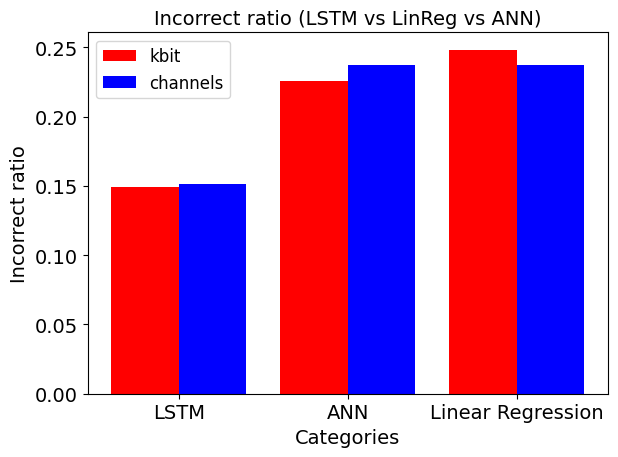

In [ ]:
categories = ["LSTM", "ANN", "Linear Regression"]

# ratio_lstm = [eval_channels_LSTM_kbit["incorrect_ratio"], eval_channels_LSTM_channels["incorrect_ratio"]]
ratio_lstm = [0.14892399267399267, 0.15127060439560439]
#ratio_ann = [ch_metrics_ANN[0]["incorrect_ratio"], ch_metrics_ANN[1]["incorrect_ratio"]]
ratio_ann = [0.22596153846153846, 0.236893315018315]
#ratio_linreg = [ch_metrics_linreg[0]["incorrect_ratio"], ch_metrics_linreg[1]["incorrect_ratio"]]
ratio_linreg = [0.24831158424908426, 0.2372367216117216]


ratio_kbit = [ratio_lstm[0], ratio_ann[0], ratio_linreg[0]]
ratio_channels = [ratio_lstm[1], ratio_ann[1], ratio_linreg[1]]
print(ratio_kbit)
print(ratio_channels)

bar_width = 0.4

x = np.arange(len(categories))

bar_kbit = plt.bar(x, ratio_kbit, bar_width, color='red', label='kbit')
bar_channels = plt.bar(x + bar_width, ratio_channels, bar_width, color='blue', label='channels')

plt.xticks(x + bar_width / 2, categories)
plt.xlabel('Categories')
plt.ylabel('Incorrect ratio')
plt.title('Incorrect ratio (LSTM vs LinReg vs ANN)')
plt.legend()

plt.tight_layout()
plt.show()


## MAE (unscaled)

LSTM vs LinReg vs ANN (unscaled MAE)

[9853.06491996095, 15118.200614223935, 15553.548226960167]


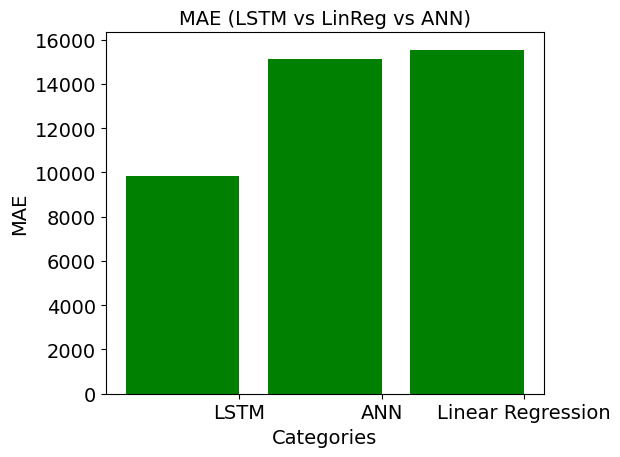

In [ ]:
categories = ["LSTM", "ANN", "Linear Regression"]

# mae_lstm = perf_LSTM_kbit["MAE"]
mae_lstm = 9853.06491996095
#mae_linreg = metrics_linreg_kbit['MAE']
mae_linreg = 15553.548226960167
#mae_ann = metrics_ann_kbit['MAE']
mae_ann =  15118.200614223935

MAE = [mae_lstm, mae_ann, mae_linreg]
print(MAE)

bar_width = 0.8

x = np.arange(len(categories))

bar_mae = plt.bar(x, MAE, bar_width, color='green')

plt.xticks(x + bar_width / 2, categories)
plt.xlabel('Categories')
plt.ylabel('MAE')
plt.title('MAE (LSTM vs LinReg vs ANN)')

plt.tight_layout()
plt.show()


## R2

LSTM vs LinReg vs ANN

[0.9604, 0.9398250282392058, 0.9369659043641996]


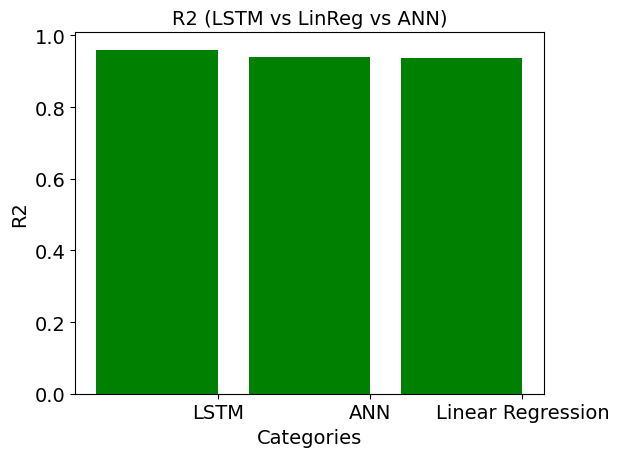

In [ ]:
categories = ["LSTM", "ANN", "Linear Regression"]

# r2_lstm = perf_LSTM_kbit["R2"]
r2_lstm = 0.960400
#r2_linreg = metrics_linreg_kbit['R2']
r2_linreg = 0.9369659043641996
#r2_ann = metrics_ann_kbit['R2']
r2_ann =  0.9398250282392058

r2 = [r2_lstm, r2_ann, r2_linreg]
print(r2)

bar_width = 0.8

x = np.arange(len(categories))

bar_mae = plt.bar(x, r2, bar_width, color='green')

plt.xticks(x + bar_width / 2, categories)
plt.xlabel('Categories')
plt.ylabel('R2')
plt.title('R2 (LSTM vs LinReg vs ANN)')

plt.tight_layout()
plt.show()


# Transfer Learning

In [ ]:
candidate_pairs_vars = []

for s, d in candidate_pairs:
  time_series = data_channels_filled[id2index(s), id2index(d),:]
  candidate_pairs_vars.append(np.var(time_series)/(max(time_series)-min(time_series)))

In [ ]:
threshold = 0.4

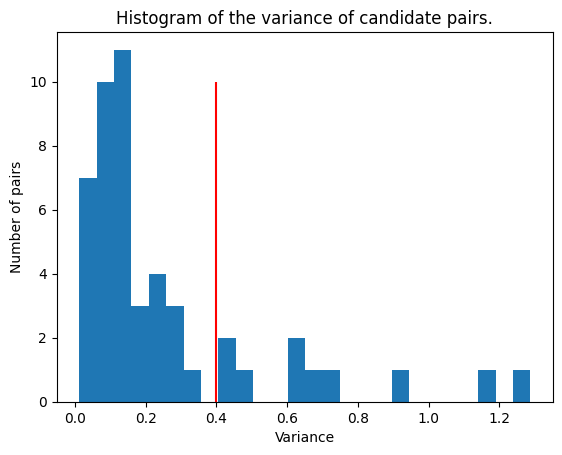

In [ ]:
plt.hist(candidate_pairs_vars, bins=int(np.ceil(max(candidate_pairs_vars)*20)))
plt.title("Histogram of the variance of candidate pairs.")
plt.xlabel("Variance")
plt.ylabel("Number of pairs")

plt.vlines(x=threshold, ymin=0, ymax=10, color="red")

plt.show()

In [ ]:
candidate_pairs_low = []
candidate_pairs_high = []

for i in range(len(candidate_pairs)):
  if candidate_pairs_vars[i] < threshold:
    candidate_pairs_low.append(candidate_pairs[i])
  else:
    candidate_pairs_high.append(candidate_pairs[i])

print(f"Number of pairs\n  Low:  {len(candidate_pairs_low)}\n  High: {len(candidate_pairs_high)}")

Number of pairs
  Low:  39
  High: 10


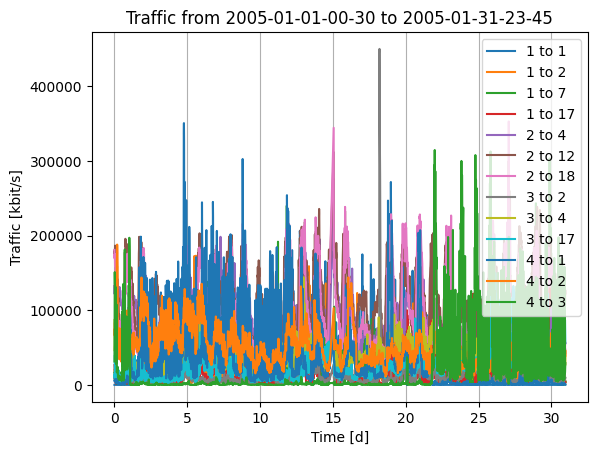

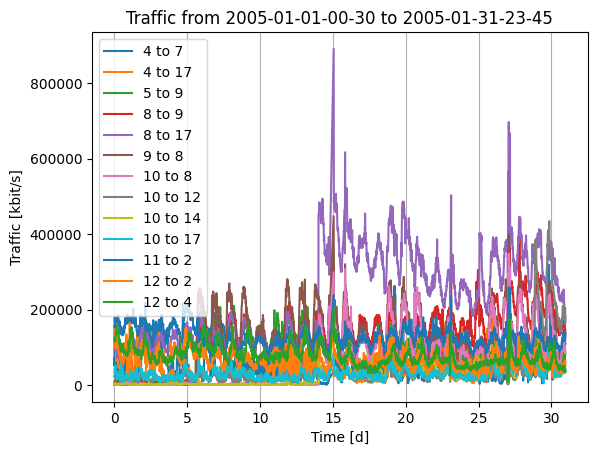

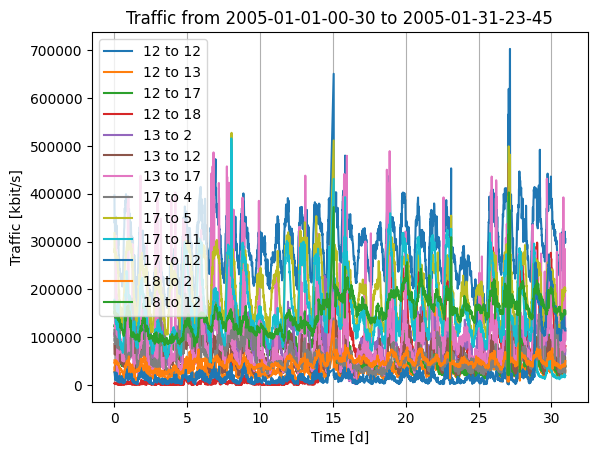

In [ ]:
p1, p2, p3 = [list(x) for x in np.array_split(range(len(candidate_pairs_low)), 3)]

plot_trace(data_kbit_filled, [candidate_pairs_low[i] for i in p1])
plot_trace(data_kbit_filled, [candidate_pairs_low[i] for i in p2])
plot_trace(data_kbit_filled, [candidate_pairs_low[i] for i in p3])

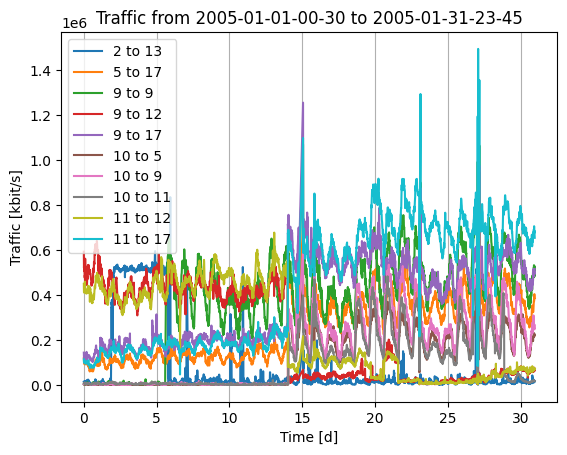

In [ ]:
plot_trace(data_kbit_filled, candidate_pairs_high)

# Deprecated

### Aggregating by hours (not used)

In [ ]:
num_hours = 31 * 24

def aggregateTrafficByHour(src, dst, data_kbit, data_channels):

  data_hour_kbit = np.zeros(num_hours)
  data_hour_channels = np.zeros(num_hours)

  hour = 0
  counter = 0


  # first day (2005-01-01) has only last 2 hour samples (at 30 and at 45) so it is a special case
  data_hour_kbit[hour] = data_kbit[src, dst, 0] + data_kbit[src, dst, 1]

  hour += 1
  # start from the third file, corresponding to day 2005-01-01 at hour 1 am

  for i, f in enumerate(files[2:]):

    counter += 1
    i += 2  # take into account the first 2 files

    data_hour_kbit[hour] += data_kbit[src, dst, i]

    if counter == 4:
      counter = 0
      hour += 1

  for i in range(len(data_hour_kbit)):
    data_hour_channels[i] = np.ceil(data_hour_kbit[i]/50000)

  return data_hour_kbit, data_hour_channels

In [ ]:
def features_extraction(data_tot, src, dst):
#Input:  - data: numpy array with all the traffic values for the entire month of January 2005
#        - src: source node of the pair
#        - dst: destination node of the pair
#Outputs: return X, y, X_unscaled, y_unscaled  where:
#         * X is the features matrix where each row is a given quarter of hour of a day, repeated for all the hours/days in the dataset, and has the following features:
#               1) source node encoded with OneHotEconder
#               2) destination node encoded with OneHotEncoder
#               3) 'day_of_week' : 0=monday, 1=tuesday, ... (knowing that January 1st 2005 was a Saturday-5, 2nd was a Sunday-6, and so on...)
#               4) 'hour' : hour of the day
#               5) 'working' : binary, =1 if working, =0 if holiday
#               6) 'prev_hour' : traffic value for the pevious hour in the same day
#               7) 'prev_day' : traffic value for the pevious day in the same hour
#         * y is the outputs vector, i.e., it has traffic values for the current day/hour (that we want to predict based on X)
#         * X_unscaled, y_unscaled are  unscaled (i.e., with real features/output values)

  if (src, dst) in candidate_pairs:   # src and dst defined as its id (from 1 to 23)
    # get the data between src and dst
    data = data_tot[id2index(src),id2index(dst)]   # here I need to convert ids into indexes (from 0 to 22)
    # interpolate the data obtained to fill the missing values
    data = interpolate_data(data)
  else:
    print("Pair {}-{} has been discarded because its data is not relevant!".format(src,dst))
    return

  # array to identify holidays indexes
  weekend_vect = np.array([1,2,6,8,9,15,16,22,23,29,30])
  # weekend_vect = np.array([0,1,5,7,8,14,15,21,22,28,29])

  ########## FEATURES EXTRACTION ################

  #source and destination
  encoder = OneHotEncoder(sparse=False)
  src_array = np.full(len(data), src)
  src_array_resh = src_array.reshape(-1, 1)
  dst_array = np.full(len(data), dst)
  dst_array_resh = dst_array.reshape(-1, 1)

  src_encoded = encoder.fit_transform(src_array_resh).flatten()
  dst_encoded = encoder.fit_transform(dst_array_resh).flatten()
  print(src_encoded.shape[0])

  day_of_the_week = [(int(f.split('-')[3])+4)%7 for f in files]   # +4 since january 1st is Saturday = day5

  hour_vect = [int(f.split('-')[4])%24 for f in files]

  working_vect = [0 if int(f.split('-')[3]) in weekend_vect else 1 for f in files]

  # first hour has only 4 values and the features is forced to be the traffic of the same hour
  prev_hour_vect = np.array([])
  for i in range(0,4):
    prev_hour_vect = np.append(prev_hour_vect, data[i])

  # first 12 hours have 48 values and their features are forced to be the same traffic
  prev_12hours_vect = np.array([])
  for i in range(0,48):
    prev_12hours_vect = np.append(prev_12hours_vect, data[i])

  # first day has 94 values and the features is forced to be the traffic of the same day
  prev_day_vect = np.array([])
  for i in range(0,96):
    prev_day_vect = np.append(prev_day_vect, data[i])

  # OUTPUT y: traffic in current day/hour
  y_unscaled = data

  for i in range(len(data)):
    if i < 4:
      continue    # skip the first hour, already inserted above
    if i < 48:
      prev_hour_vect = np.append(prev_hour_vect, data[i-4])
      continue
    if i < 96:      # skip the first day, already inserted above (we insert only  in prev_hour_vect)
      prev_hour_vect = np.append(prev_hour_vect, data[i-4])
      prev_12hours_vect = np.append(prev_12hours_vect, data[i-48])
      continue

    prev_hour_vect = np.append(prev_hour_vect, data[i-4])
    prev_12hours_vect = np.append(prev_12hours_vect, data[i-48])
    prev_day_vect = np.append(prev_day_vect, data[i-96])

  # print(len(src_encoded), len(dst_encoded), len(day_of_the_week), len(hour_vect), len(working_vect), len(prev_hour_vect), len(prev_12hours_vect), len(prev_day_vect))

####################################################
  Xdf = pd.DataFrame.from_dict({
    'source': src_encoded,
    'destination': dst_encoded,
    'day_of_the_week' : day_of_the_week,
    'hour' : hour_vect,
    'working_day' : working_vect,
    'prev_hour' : prev_hour_vect,
    'prev_12hours': prev_12hours_vect,
    'prev_day' : prev_day_vect})


  X_unscaled = Xdf.to_numpy() #we want all outputs as ndarrays, the other outputs are already transformed with reshape() or fit_transform
  y_unscaled = np.reshape(y_unscaled, (-1, 1)) #needed to feed fit_transform(y_unscaled) below

  return X_unscaled, y_unscaled #X_unscaled, y_unscaled are numpy ndarrays


#### Test linear regression on all candidate pairs

Compare the results (in terms of r2 and mse) for all the candidate pairs to have an overview of the performance of linear regression!

In [ ]:

# linreg_results = {
#     'pair': [],
#     'r2': [],
#     'mse': []
# }

# for pair in candidate_pairs:
#   try:
#     Xraw, yraw = features_extraction(data_kbit_filled, pair[0], pair[1])
#   except:
#     print('Pair {}-{} has problematic data (skip this pair)'.format(pair[0], pair[1]))
#     continue

#   X_train, X_test, y_train, y_test = train_test_split(Xraw, yraw, perc_tr)
#   linreg, train_duration_linreg = train_linreg(X_train, y_train)

#   r2_linreg = linreg.score(X_test, y_test)
#   y_pred_linreg = linreg.predict(X_test)
#   mse_linreg = mean_squared_error(y_test, y_pred_linreg)

#   linreg_results['pair'].append(pair)
#   linreg_results['r2'].append(r2_linreg)
#   linreg_results['mse'].append(mse_linreg)

# worst_pairs, best_pairs = [], []
# min_threshold, max_threshold = 0, 0.65

# for pair, r2 in zip(linreg_results['pair'], linreg_results['r2']):
#   if r2 < min_threshold:
#     worst_pairs.append(pair)
#   if r2 > max_threshold:
#     best_pairs.append(pair)

# # plot_trace(data_kbit, worst_pairs)
# # plot_trace(data_kbit, best_pairs)

# display(pd.DataFrame(linreg_results))
